# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>


**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

In [1]:
## Import Packages

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


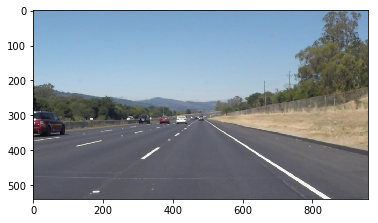

In [3]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [37]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    #return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=14):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    lineLeft = []
    lineRight= []
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = ((y2-y1)/(x2-x1))
            if slope <= 0:
                lineLeft.append(line)
            else:
                lineRight.append(line)
    #for x1,y1,x2,y2 in lineLeft:
    lineLeftAvg = []
    lineRightAvg = []
    if np.array(lineLeft).any():
        lineLeftAvg = np.average(lineLeft, axis = 0)
    if np.array(lineRight).any():
        lineRightAvg = np.average(lineRight, axis = 0)

    print('left avg', lineLeftAvg)
    print('right avg', lineRightAvg)
    
    # @TODO Hardcoding is bad. Innovate!
    minY = 311
    maxY = img.shape[0]
    
    if  np.array(lineLeftAvg).any() and lineLeftAvg.any() !=  np.nan: 
        x1LeftAvg,y1LeftAvg,x2LeftAvg,y2LeftAvg = lineLeftAvg[0]
        [slopeLeft, interceptLeft] = np.polyfit([x1LeftAvg, x2LeftAvg ], [y1LeftAvg, y2LeftAvg], 1)
        minLeftX = math.floor((minY - interceptLeft) / slopeLeft)
        maxLeftX = math.floor((maxY - interceptLeft) / slopeLeft)
        # Left Lane            
        cv2.line(img, (minLeftX, minY), (maxLeftX, maxY), color, thickness)
        
    if  np.array(lineRightAvg).any() and lineRightAvg.any() != np.nan: 
        x1RightAvg,y1RightAvg,x2RightAvg,y2RightAvg = lineRightAvg[0]
        [slopeRight, interceptRight] = np.polyfit([x1RightAvg, x2RightAvg ], [y1RightAvg, y2RightAvg], 1)
        minRightX = math.floor((minY - interceptRight) / slopeRight)
        maxRightX = math.floor((maxY - interceptRight) / slopeRight) 
        # Right lane 
        cv2.line(img, (minRightX, minY), (maxRightX, maxY), color, thickness)
    
    
    
    
    
    
    
    
    
    
        

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [38]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

left avg [[ 277.          468.11111111  385.22222222  388.22222222]]
right avg [[ 750.75  467.75  856.25  528.75]]


True

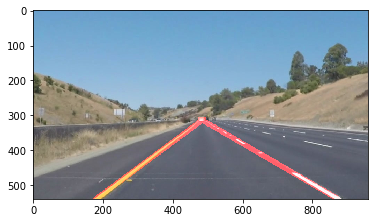

In [39]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

def pipeline(image):
    
    # Grayscale the image
    grayscaleImage = grayscale(image)
    
    # Define a kernel size and apply Gaussian smoothing
    gaussBlurImage = gaussian_blur(grayscaleImage, kernel_size = 7)
    cannyImage = canny(gaussBlurImage, low_threshold = 50, high_threshold =150)
     
    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    vertices = np.array([[(150,imshape[0]),(450, 311), (470, 311), (950,imshape[0])]], dtype=np.int32)
    roiImage = region_of_interest(cannyImage, vertices)
    # Define the Hough transform parameters
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 40 #minimum number of pixels making up a line
    max_line_gap = 20    # maximum gap in pixels between connectable line segments
    line_image = hough_lines(roiImage, rho, theta, threshold, min_line_len, max_line_gap)
    
    weightedImage = weighted_img(image, line_image, α=0.8, β=1., γ=0.)  
    return weightedImage
    
# Read in the image
image = mpimg.imread("test_images/whiteCarLaneSwitch.jpg")
weightedImage = pipeline(image)
plt.imshow(weightedImage)
cv2.imwrite("test_images_output/whiteCarLaneSwitch_Output.jpg", weightedImage)

    
    

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [40]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [41]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    result = pipeline(image) 
    # you should return the final output (image where lines are drawn on lanes)

    return result

Let's try the one with the solid white lane on the right first ...

In [44]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

left avg [[ 209.          500.66666667  276.16666667  452.        ]]
right avg [[ 640.85714286  406.28571429  752.71428571  474.28571429]]
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4





  0%|          | 0/222 [00:00<?, ?it/s]

left avg [[ 209.          500.66666667  276.16666667  452.        ]]
right avg [[ 640.85714286  406.28571429  752.71428571  474.28571429]]
left avg [[ 215.14285714  496.          290.42857143  440.85714286]]
right avg [[ 645.57142857  406.71428571  768.71428571  482.42857143]]
left avg [[ 299.66666667  436.83333333  355.33333333  396.83333333]]
right avg [[ 647.66666667  408.22222222  735.11111111  461.88888889]]
left avg [[ 350.57142857  401.42857143  397.42857143  365.85714286]]
right avg [[ 596.8  378.2  773.2  486.2]]





  2%|▏         | 4/222 [00:00<00:06, 32.52it/s]

left avg [[ 419.    348.25  465.    315.  ]]
right avg [[ 650.71428571  412.57142857  804.14285714  506.        ]]
left avg [[ 417.5  350.   462.5  316.5]]
right avg [[ 645.5    409.25   765.     482.125]]
left avg [[ 393.5   366.75  467.    313.75]]
right avg [[ 636.5  403.   769.5  484.5]]
left avg [[ 382.8  374.4  440.2  332. ]]
right avg [[ 580.5   366.25  837.5   523.75]]
left avg [[ 355.28571429  392.57142857  415.42857143  349.28571429]]
right avg [[ 645.66666667  408.83333333  820.66666667  516.16666667]]





  4%|▍         | 9/222 [00:00<00:05, 38.30it/s]

left avg [[ 339.5   405.75  402.25  361.5 ]]
right avg [[ 636.   402.6  739.3  465.8]]
left avg [[ 339.85714286  407.42857143  412.85714286  355.71428571]]
right avg [[ 612.5         392.5         743.16666667  473.        ]]
left avg [[ 313.85714286  427.14285714  381.28571429  378.85714286]]
right avg [[ 659.36363636  421.72727273  737.54545455  470.        ]]
left avg [[ 310.125  425.875  385.625  375.75 ]]
right avg [[ 633.14285714  405.14285714  771.57142857  493.42857143]]
left avg [[ 273.          453.66666667  342.66666667  403.33333333]]
right avg [[ 638.25   407.875  767.625  490.125]]





  6%|▋         | 14/222 [00:00<00:04, 41.67it/s]

left avg [[ 335.16666667  408.5         389.33333333  369.5       ]]
right avg [[ 613.25  391.75  758.    484.75]]
left avg [[ 315.6  421.2  365.6  385.8]]
right avg [[ 611.4  387.8  773.6  492.6]]
left avg [[ 417.5  344.5  462.5  311. ]]
right avg [[ 638.          405.42857143  761.14285714  484.42857143]]
left avg [[ 416.25  347.25  463.25  313.75]]
right avg [[ 602.16666667  382.          756.5         481.83333333]]
left avg [[ 389.2  368.2  454.6  322.6]]
right avg [[ 642.33333333  410.66666667  796.          507.83333333]]
left avg [[ 393.5   367.25  469.    313.75]]
right avg [[ 603.   385.6  803.   512.4]]





  9%|▉         | 20/222 [00:00<00:04, 43.96it/s]

left avg [[ 366.11111111  387.44444444  420.88888889  348.66666667]]
right avg [[ 631.66666667  405.33333333  801.16666667  513.33333333]]
left avg [[ 344.875  402.75   404.25   361.625]]
right avg [[ 583.8  374.4  819.6  524.4]]
left avg [[ 301.25  431.5   357.75  393.  ]]
right avg [[ 617.6  393.4  799.2  509. ]]
left avg [[ 312.          425.42857143  362.71428571  388.71428571]]
right avg [[ 594.    378.75  784.25  500.25]]
left avg [[ 253.66666667  467.33333333  318.83333333  421.66666667]]
right avg [[ 669.54545455  425.45454545  753.90909091  478.54545455]]





 11%|█▏        | 25/222 [00:00<00:04, 44.48it/s]

left avg [[ 236.66666667  480.66666667  296.66666667  436.83333333]]
right avg [[ 607.66666667  388.          754.          482.16666667]]
left avg [[ 165.   537.   237.5  484.5]]
right avg [[ 583.5  371.5  744.5  474. ]]
left avg [[ 165.   538.5  225.   493.5]]
right avg [[ 596.14285714  381.57142857  764.42857143  488.28571429]]
left avg []
right avg [[ 594.75  379.25  832.75  530.5 ]]
left avg [[ 417.          350.33333333  465.          316.        ]]
right avg [[ 618.83333333  394.66666667  786.66666667  500.83333333]]





 14%|█▎        | 30/222 [00:00<00:04, 44.91it/s]

left avg [[ 414.   352.5  469.   314.5]]
right avg [[ 603.14285714  382.85714286  744.71428571  473.        ]]
left avg [[ 393.6  366.2  453.2  322. ]]
right avg [[ 617.   392.2  774.8  492. ]]
left avg [[ 373.57142857  380.85714286  428.42857143  341.42857143]]
right avg [[ 664.          419.85714286  769.85714286  487.28571429]]
left avg [[ 344.          402.          397.16666667  364.16666667]]
right avg [[ 597.66666667  380.33333333  741.66666667  471.66666667]]
left avg [[ 339.42857143  405.71428571  397.57142857  363.14285714]]
right avg [[ 602.28571429  383.          761.14285714  483.42857143]]





 16%|█▌        | 35/222 [00:00<00:04, 44.76it/s]

left avg [[ 290.42857143  440.28571429  351.57142857  397.57142857]]
right avg [[ 551.75  352.5   824.75  526.5 ]]
left avg [[ 282.5    447.     349.     400.375]]
right avg [[ 545.6  348.8  740.2  472.6]]
left avg [[ 236.2  481.6  309.8  428. ]]
right avg [[ 650.14285714  416.71428571  776.71428571  497.71428571]]
left avg [[ 185.    521.25  248.5   475.  ]]
right avg [[ 622.42857143  397.          734.85714286  470.        ]]
left avg [[ 164.   538.5  228.5  490. ]]
right avg [[ 632.83333333  402.83333333  757.83333333  483.66666667]]





 18%|█▊        | 40/222 [00:00<00:04, 45.05it/s]

left avg []
right avg [[ 639.71428571  407.57142857  754.          480.71428571]]
left avg []
right avg [[ 613.125  391.25   736.875  471.75 ]]
left avg [[ 365.16666667  386.66666667  439.16666667  331.33333333]]
right avg [[ 647.1  411.4  731.6  466.4]]
left avg [[ 386.16666667  370.5         448.83333333  323.        ]]
right avg [[ 626.6  399.6  753.4  481.4]]
left avg [[ 359.   388.4  421.2  345.4]]
right avg [[ 562.25  356.25  769.    491.5 ]]





 20%|██        | 45/222 [00:01<00:03, 44.55it/s]

left avg [[ 354.66666667  391.83333333  423.33333333  343.66666667]]
right avg [[ 636.125  405.75   748.     478.625]]
left avg [[ 324.2  415.4  378.8  374.2]]
right avg [[ 667.22222222  421.66666667  768.66666667  488.77777778]]
left avg [[ 294.   437.   356.   391.5]]
right avg [[ 644.875  410.75   757.25   483.875]]
left avg [[ 292.83333333  438.5         350.16666667  396.33333333]]
right avg [[ 648.28571429  411.57142857  766.42857143  489.14285714]]
left avg [[ 161.5  538.   257.5  466. ]]
right avg [[ 644.85714286  407.57142857  776.85714286  495.        ]]





 23%|██▎       | 50/222 [00:01<00:03, 43.59it/s]

left avg [[ 161.   538.5  261.5  463. ]]
right avg [[ 614.85714286  389.14285714  748.42857143  476.        ]]
left avg [[ 164.   533.5  221.5  492. ]]
right avg [[ 614.33333333  390.5         758.33333333  484.33333333]]
left avg [[ 416.33333333  346.          460.66666667  314.66666667]]
right avg [[ 591.8  375.   724.   460.8]]
left avg [[ 368.          380.33333333  425.          341.66666667]]
right avg [[ 584.   370.2  742.2  473.6]]
left avg [[ 402.          355.33333333  466.66666667  312.66666667]]
right avg [[ 641.14285714  405.57142857  760.14285714  483.57142857]]





 25%|██▍       | 55/222 [00:01<00:03, 42.77it/s]

left avg [[ 399.    361.    468.75  312.75]]
right avg [[ 644.57142857  410.42857143  766.57142857  489.        ]]
left avg [[ 354.42857143  392.          413.28571429  351.28571429]]
right avg [[ 591.125  379.     725.375  464.625]]
left avg [[ 351.83333333  392.83333333  425.16666667  344.66666667]]
right avg [[ 585.625  375.875  710.125  455.   ]]
left avg [[ 346.14285714  397.85714286  415.85714286  351.42857143]]
right avg [[ 667.27272727  428.36363636  751.72727273  481.72727273]]





 27%|██▋       | 59/222 [00:01<00:03, 42.35it/s]

left avg [[ 333.6  407.6  405.4  357.8]]
right avg [[ 677.875  434.125  754.375  483.125]]
left avg [[ 277.33333333  448.33333333  341.66666667  402.33333333]]
right avg [[ 636.55555556  408.11111111  743.88888889  478.33333333]]
left avg [[ 152.   538.5  254.   464.5]]
right avg [[ 660.83333333  425.          805.16666667  520.        ]]
left avg [[ 175.    522.    235.75  478.  ]]
right avg [[ 554.    355.    727.75  469.75]]





 28%|██▊       | 63/222 [00:01<00:03, 41.61it/s]

left avg [[ 375.          378.66666667  427.33333333  344.        ]]
right avg [[ 632.          405.16666667  777.16666667  500.16666667]]
left avg [[ 417.   348.5  471.   312.5]]
right avg [[ 596.25  383.5   741.75  479.75]]
left avg [[ 414.5  351.5  471.5  313.5]]
right avg [[ 598.16666667  383.16666667  755.5         486.83333333]]
left avg [[ 410.5   350.75  464.25  314.5 ]]
right avg [[ 646.75   416.125  752.25   485.875]]





 30%|███       | 67/222 [00:01<00:03, 41.28it/s]

left avg [[ 393.   363.2  449.6  323. ]]
right avg [[ 628.14285714  401.71428571  754.71428571  485.28571429]]
left avg [[ 369.4  378.2  425.   341.4]]
right avg [[ 610.          389.14285714  737.57142857  473.        ]]
left avg [[ 381.42857143  371.85714286  440.71428571  331.71428571]]
right avg [[ 615.28571429  394.28571429  765.42857143  493.85714286]]
left avg [[ 346.33333333  395.66666667  406.66666667  353.33333333]]
right avg [[ 622.5  401.1  698.4  449.7]]





 32%|███▏      | 71/222 [00:01<00:03, 40.88it/s]

left avg [[ 306.8  424.2  363.4  384.4]]
right avg [[ 604.83333333  388.          770.66666667  497.33333333]]
left avg [[ 319.5   415.25  379.5   373.  ]]
right avg [[ 636.16666667  408.16666667  776.          499.83333333]]
left avg [[ 324.   411.   375.   376.5]]
right avg [[ 578.57142857  369.85714286  738.57142857  476.14285714]]
left avg [[ 421.5  342.   467.5  311. ]]
right avg [[ 589.16666667  377.          753.5         486.5       ]]





 34%|███▍      | 75/222 [00:01<00:03, 40.74it/s]

left avg [[ 419.   342.5  464.   312. ]]
right avg [[ 590.66666667  379.          728.          470.        ]]
left avg [[ 414.    348.    466.75  312.  ]]
right avg [[ 589.75   381.875  710.125  461.25 ]]
left avg [[ 410.5  350.   464.   311.5]]
right avg [[ 567.66666667  366.83333333  748.5         486.16666667]]
left avg [[ 390.2  363.8  461.4  316.4]]
right avg [[ 610.625  395.75   707.625  459.625]]





 36%|███▌      | 79/222 [00:01<00:03, 40.27it/s]

left avg [[ 373.5   376.25  434.    333.5 ]]
right avg [[ 604.4  388.9  699.3  453.9]]
left avg [[ 376.5         372.5         429.16666667  337.5       ]]
right avg [[ 587.5         377.83333333  743.66666667  483.16666667]]
left avg [[ 360.    383.25  418.5   344.5 ]]
right avg [[ 636.71428571  410.85714286  747.85714286  487.42857143]]
left avg [[ 357.    385.5   414.25  347.5 ]]
right avg [[ 604.2  388.8  734.   477.2]]





 37%|███▋      | 83/222 [00:02<00:03, 40.16it/s]

left avg [[ 342.          396.66666667  387.33333333  364.33333333]]
right avg [[ 606.   388.5  733.   475.5]]
left avg [[ 385.  368.  442.  328.]]
right avg [[ 619.85714286  397.71428571  726.57142857  471.28571429]]
left avg [[ 422.6  342.4  469.   312.2]]
right avg [[ 637.33333333  413.          742.11111111  485.22222222]]
left avg []
right avg [[ 627.66666667  406.16666667  750.83333333  491.        ]]





 39%|███▉      | 87/222 [00:02<00:03, 39.89it/s]

left avg [[ 416.5  346.   466.5  313.5]]
right avg [[ 632.85714286  409.42857143  771.42857143  505.42857143]]
left avg [[ 414.33333333  347.66666667  466.33333333  312.33333333]]
right avg [[ 612.   394.6  784.2  513.6]]
left avg [[ 412.  348.  468.  312.]]
right avg [[ 572.5   369.    789.5   518.75]]
left avg [[ 374.4  377.6  423.8  342. ]]
right avg [[ 637.5    413.125  748.75   490.125]]





 41%|████      | 91/222 [00:02<00:03, 39.72it/s]

left avg [[ 389.75  367.5   448.75  327.75]]
right avg [[ 627.16666667  407.33333333  744.66666667  489.16666667]]
left avg [[ 359.16666667  387.33333333  416.5         348.83333333]]
right avg [[ 623.875  403.875  736.375  482.   ]]
left avg [[ 336.75  402.5   397.75  362.75]]
right avg [[ 614.3  396.9  703.1  457.7]]
left avg [[ 337.   403.   394.8  362.8]]
right avg [[ 651.5         422.5         742.33333333  485.5       ]]
left avg [[ 312.2  419.2  371.   380.4]]
right avg [[ 656.22222222  423.11111111  745.66666667  484.11111111]]





 43%|████▎     | 96/222 [00:02<00:03, 39.70it/s]

left avg [[ 248.5  464.5  301.   427.5]]
right avg [[ 623.66666667  400.5         762.83333333  498.16666667]]
left avg []
right avg [[ 571.5   363.5   713.5   463.25]]
left avg []
right avg [[ 652.          418.44444444  762.88888889  496.66666667]]
left avg []
right avg [[ 653.28571429  421.85714286  761.42857143  496.        ]]





 45%|████▌     | 100/222 [00:02<00:03, 39.67it/s]

left avg []
right avg [[ 613.2  391.6  779.4  508. ]]
left avg []
right avg [[ 590.  378.  749.  489.]]
left avg []
right avg [[ 626.77777778  403.11111111  706.11111111  457.11111111]]
left avg [[ 376.5         377.66666667  444.33333333  332.33333333]]
right avg [[ 653.44444444  420.33333333  757.22222222  491.44444444]]





 47%|████▋     | 104/222 [00:02<00:02, 39.57it/s]

left avg [[ 359.85714286  389.          410.14285714  354.14285714]]
right avg [[ 610.6  390.2  798.4  519.6]]
left avg [[ 343.75   399.25   407.125  356.125]]
right avg [[ 650.71428571  416.57142857  777.          503.85714286]]
left avg [[ 340.83333333  401.66666667  395.33333333  365.83333333]]
right avg [[ 596.5         381.66666667  754.33333333  489.66666667]]
left avg [[ 367.25  383.    428.5   341.5 ]]
right avg [[ 558.75  353.5   773.    500.5 ]]





 49%|████▊     | 108/222 [00:02<00:02, 39.50it/s]

left avg [[ 211.5  495.   312.   424.5]]
right avg [[ 652.     416.625  743.625  479.625]]
left avg [[ 299.5   432.75  373.25  380.75]]
right avg [[ 659.4  422.9  745.8  482.5]]
left avg [[ 176.5  522.   266.   458.5]]
right avg [[ 633.375  406.875  741.     480.375]]
left avg [[ 165.   530.5  209.5  498. ]]
right avg [[ 637.14285714  405.          769.42857143  496.85714286]]





 50%|█████     | 112/222 [00:02<00:02, 39.38it/s]

left avg [[ 424.   345.   470.   312.5]]
right avg [[ 634.66666667  403.5         789.5         510.33333333]]
left avg [[ 418.          347.66666667  465.33333333  315.33333333]]
right avg [[ 674.6  432.2  752.   484.3]]
left avg [[ 414.75  350.25  466.25  315.  ]]
right avg [[ 610.57142857  387.14285714  747.14285714  480.        ]]
left avg [[ 414.33333333  350.          465.33333333  316.66666667]]
right avg [[ 654.28571429  416.57142857  743.42857143  475.        ]]





 52%|█████▏    | 116/222 [00:02<00:02, 39.30it/s]

left avg [[ 346.2  395.8  396.6  362.2]]
right avg [[ 630.          398.66666667  746.          476.66666667]]
left avg [[ 344.16666667  398.83333333  400.5         360.83333333]]
right avg [[ 636.16666667  404.16666667  765.          490.16666667]]
left avg [[ 365.5   383.75  422.25  346.25]]
right avg [[ 630.5    402.25   748.75   481.625]]
left avg [[ 369.8  382.4  440.8  336.4]]
right avg [[ 620.          393.33333333  749.16666667  479.66666667]]





 54%|█████▍    | 120/222 [00:03<00:02, 39.28it/s]

left avg [[ 274.5   451.5   336.    409.25]]
right avg [[ 639.2  407.3  727.2  465.9]]
left avg [[ 339.33333333  404.16666667  415.          356.33333333]]
right avg [[ 617.75  392.    788.5   501.75]]
left avg [[ 355.57142857  393.28571429  414.85714286  355.14285714]]
right avg [[ 627.57142857  397.71428571  767.57142857  489.14285714]]
left avg [[ 290.          440.5         350.33333333  399.        ]]
right avg [[ 619.33333333  393.33333333  705.55555556  449.        ]]





 56%|█████▌    | 124/222 [00:03<00:02, 39.22it/s]

left avg [[ 421.75  346.75  468.25  315.25]]
right avg [[ 662.83333333  418.66666667  795.33333333  506.66666667]]
left avg [[ 420.4  350.2  471.8  314.6]]
right avg [[ 668.          425.57142857  811.          516.57142857]]
left avg []
right avg [[ 548.33333333  348.          792.33333333  504.33333333]]
left avg [[ 416.6  353.   471.6  314.4]]
right avg [[ 635.83333333  400.83333333  796.33333333  503.5       ]]





 58%|█████▊    | 128/222 [00:03<00:02, 39.19it/s]

left avg [[ 370.16666667  386.          420.66666667  349.        ]]
right avg [[ 589.   372.   796.8  504.6]]
left avg [[ 355.14285714  396.          410.57142857  357.57142857]]
right avg [[ 623.66666667  393.66666667  791.          500.83333333]]
left avg [[ 340.42857143  408.          400.57142857  366.28571429]]
right avg [[ 618.          390.33333333  798.16666667  505.5       ]]
left avg [[ 342.4  406.4  403.4  363.6]]
right avg [[ 612.75   390.125  741.75   471.625]]





 59%|█████▉    | 132/222 [00:03<00:02, 39.12it/s]

left avg [[ 301.57142857  436.28571429  373.85714286  384.        ]]
right avg [[ 644.4  406.8  803.4  508.6]]
left avg [[ 260.33333333  464.33333333  338.          408.83333333]]
right avg [[ 601.   381.2  795.6  505. ]]
left avg [[ 196.    508.75  271.75  455.  ]]
right avg [[ 616.66666667  391.          761.5         482.5       ]]
left avg [[ 175.5  528.5  249.   472.5]]
right avg [[ 607.   382.4  775.6  489.4]]





 61%|██████▏   | 136/222 [00:03<00:02, 39.06it/s]

left avg [[ 160.5  538.5  208.5  503. ]]
right avg [[ 673.          421.33333333  813.5         511.83333333]]
left avg []
right avg [[ 617.4  387.6  780.8  491.8]]
left avg []
right avg [[ 652.14285714  412.14285714  736.42857143  466.        ]]
left avg []
right avg [[ 666.4  420.4  823.4  520.2]]





 63%|██████▎   | 140/222 [00:03<00:02, 39.07it/s]

left avg [[ 391.66666667  371.16666667  444.          334.16666667]]
right avg [[ 656.33333333  416.88888889  752.66666667  477.77777778]]
left avg [[ 372.9  384.3  433.4  343.8]]
right avg [[ 578.75  367.5   828.75  526.75]]
left avg [[ 356.375  398.625  423.875  349.875]]
right avg [[ 637.          405.57142857  769.28571429  490.42857143]]
left avg [[ 338.57142857  410.14285714  400.71428571  365.42857143]]
right avg [[ 594.75  378.5   788.    502.  ]]





 65%|██████▍   | 144/222 [00:03<00:01, 39.01it/s]

left avg [[ 325.14285714  420.14285714  389.42857143  373.28571429]]
right avg [[ 609.16666667  385.66666667  764.83333333  484.33333333]]
left avg [[ 258.25   468.75   329.75   417.125]]
right avg [[ 644.6  404.8  824.4  520.2]]
left avg [[ 181.   522.8  270.6  457.6]]
right avg [[ 670.    421.25  780.75  492.  ]]
left avg [[ 172.          528.          247.33333333  473.66666667]]
right avg [[ 671.85714286  419.42857143  807.42857143  505.85714286]]





 67%|██████▋   | 148/222 [00:03<00:01, 38.84it/s]

left avg [[ 163.66666667  538.33333333  211.66666667  503.33333333]]
right avg [[ 663.25  414.75  766.75  480.  ]]
left avg [[ 424.66666667  349.33333333  470.          317.        ]]
right avg [[ 685.5    432.25   779.75   489.875]]
left avg [[ 422.  351.  468.  317.]]
right avg [[ 692.77777778  434.11111111  776.88888889  486.        ]]
left avg [[ 403.    364.5   469.25  316.25]]
right avg [[ 678.14285714  426.          784.85714286  492.28571429]]





 68%|██████▊   | 152/222 [00:03<00:01, 38.85it/s]

left avg [[ 370.8  387.4  421.8  351.2]]
right avg [[ 622.8  390.   794.6  499. ]]
left avg [[ 348.85714286  403.42857143  399.71428571  366.42857143]]
right avg [[ 623.8  389.2  772.2  483.2]]
left avg [[ 360.71428571  393.14285714  411.28571429  358.14285714]]
right avg [[ 657.875  411.375  775.75   486.25 ]]
left avg [[ 332.375  415.     394.75   368.75 ]]
right avg [[ 663.4  412.4  837.8  524. ]]





 70%|███████   | 156/222 [00:04<00:01, 38.86it/s]

left avg [[ 320.375  422.     380.25   379.5  ]]
right avg [[ 660.     409.875  804.625  502.25 ]]
left avg [[ 247.     476.625  322.25   421.75 ]]
right avg [[ 661.66666667  414.          800.          500.16666667]]
left avg [[ 285.77777778  451.11111111  354.22222222  399.66666667]]
right avg [[ 692.          430.44444444  787.88888889  488.88888889]]
left avg [[ 182.    528.    246.    480.75]]
right avg [[ 625.5         391.66666667  740.          461.33333333]]





 72%|███████▏  | 160/222 [00:04<00:01, 38.82it/s]

left avg [[ 299.125  442.375  342.5    409.5  ]]
right avg [[ 655.16666667  405.16666667  816.66666667  504.33333333]]
left avg []
right avg [[ 695.28571429  430.71428571  806.71428571  498.85714286]]
left avg []
right avg [[ 703.4  434.4  859.2  528.2]]
left avg [[ 422.33333333  351.          470.66666667  316.        ]]
right avg [[ 654.4  406.4  821.6  507.4]]





 74%|███████▍  | 164/222 [00:04<00:01, 38.77it/s]

left avg [[ 388.8  377.8  440.4  339. ]]
right avg [[ 704.22222222  435.66666667  807.55555556  496.66666667]]
left avg [[ 365.57142857  396.          420.          354.71428571]]
right avg [[ 628.6  393.6  852.   524.8]]
left avg [[ 352.5         407.83333333  413.66666667  361.83333333]]
right avg [[ 635.16666667  398.5         797.33333333  493.5       ]]
left avg [[ 341.44444444  416.11111111  404.55555556  367.11111111]]
right avg [[ 574.75  361.5   804.5   496.  ]]





 76%|███████▌  | 168/222 [00:04<00:01, 38.71it/s]

left avg [[ 322.16666667  430.33333333  391.33333333  376.83333333]]
right avg [[ 652.25  407.25  872.    537.25]]
left avg [[ 316.     436.5    393.5    376.125]]
right avg [[ 660.75  412.5   870.25  536.5 ]]
left avg [[ 260.71428571  478.42857143  336.85714286  418.57142857]]
right avg [[ 591.2  372.6  769.8  478.4]]
left avg [[ 285.8  459.4  342.4  415.4]]
right avg [[ 597.2  374.6  810.8  501. ]]





 77%|███████▋  | 172/222 [00:04<00:01, 38.61it/s]

left avg [[ 180.25  538.    226.    503.  ]]
right avg [[ 566.66666667  358.          789.66666667  489.33333333]]
left avg []
right avg [[ 643.75  404.75  816.    506.5 ]]
left avg [[ 422.5  351.5  469.5  315. ]]
right avg [[ 634.8  396.   795.   490.2]]
left avg []
right avg [[ 680.          421.57142857  792.42857143  487.71428571]]





 79%|███████▉  | 176/222 [00:04<00:01, 38.63it/s]

left avg [[ 421.25  356.    470.5   316.5 ]]
right avg [[ 585.    368.25  864.5   533.  ]]
left avg [[ 377.8  386.5  427.6  350.8]]
right avg [[ 652.71428571  407.71428571  775.57142857  479.71428571]]
left avg [[ 372.71428571  390.57142857  424.28571429  353.28571429]]
right avg [[ 648.16666667  405.66666667  813.33333333  502.83333333]]
left avg [[ 341.83333333  416.5         400.16666667  369.33333333]]
right avg [[ 653.    405.25  876.75  538.25]]





 81%|████████  | 180/222 [00:04<00:01, 38.59it/s]

left avg [[ 342.28571429  417.85714286  409.85714286  363.57142857]]
right avg [[ 602.8  376.8  812.4  500.4]]
left avg [[ 297.875  452.125  367.625  400.625]]
right avg [[ 652.5    404.5    762.25   468.625]]
left avg [[ 234.66666667  501.5         304.66666667  445.16666667]]
right avg [[ 652.875  405.75   761.25   469.625]]
left avg [[ 203.   530.2  271.2  474.6]]
right avg [[ 658.75   410.125  769.125  474.625]]





 83%|████████▎ | 184/222 [00:04<00:00, 38.53it/s]

left avg [[ 190.    538.    237.25  499.75]]
right avg [[ 697.36363636  430.90909091  789.09090909  484.63636364]]
left avg [[ 427.  349.  470.  313.]]
right avg [[ 644.66666667  400.5         787.          486.16666667]]
left avg [[ 378.6  387.4  451.8  327.2]]
right avg [[ 678.375  422.375  790.75   489.125]]
left avg [[ 376.          387.33333333  445.66666667  331.66666667]]
right avg [[ 625.66666667  388.33333333  825.33333333  505.33333333]]





 85%|████████▍ | 188/222 [00:04<00:00, 38.48it/s]

left avg [[ 402.6  364.8  444.   332.6]]
right avg [[ 652.   400.2  841.6  512. ]]
left avg [[ 362.          392.66666667  409.83333333  355.5       ]]
right avg [[ 675.33333333  411.5         786.83333333  477.        ]]
left avg [[ 368.33333333  391.          421.83333333  346.83333333]]
right avg [[ 702.85714286  427.71428571  824.57142857  497.57142857]]
left avg [[ 349.6  408.2  416.8  355. ]]
right avg [[ 663.8  408.2  813.8  492.8]]





 86%|████████▋ | 192/222 [00:04<00:00, 38.46it/s]

left avg [[ 332.22222222  424.66666667  393.33333333  376.        ]]
right avg [[ 686.88888889  423.22222222  772.55555556  473.66666667]]
left avg [[ 303.71428571  449.          367.28571429  399.57142857]]
right avg [[ 661.16666667  410.5         795.5         488.33333333]]
left avg [[ 247.          490.5         312.          439.33333333]]
right avg [[ 651.2  405.   833.4  512.2]]
left avg [[ 229.66666667  504.83333333  288.83333333  458.16666667]]
right avg [[ 598.8  374.4  825.2  507.4]]





 88%|████████▊ | 196/222 [00:05<00:00, 38.43it/s]

left avg [[ 189.    537.5   233.75  501.5 ]]
right avg [[ 584.    365.5   759.25  468.5 ]]
left avg []
right avg [[ 631.75  393.    850.75  521.  ]]
left avg [[ 423.  351.  475.  315.]]
right avg [[ 685.83333333  422.66666667  820.5         501.5       ]]
left avg [[ 377.33333333  389.          447.66666667  332.5       ]]
right avg [[ 680.88888889  420.11111111  788.88888889  483.88888889]]





 90%|█████████ | 200/222 [00:05<00:00, 38.42it/s]

left avg [[ 397.6  371.4  453.8  326.4]]
right avg [[ 658.85714286  407.85714286  762.85714286  468.28571429]]
left avg [[ 375.16666667  389.          429.          346.5       ]]
right avg [[ 685.28571429  423.85714286  810.28571429  495.        ]]
left avg [[ 361.14285714  399.14285714  421.57142857  353.14285714]]
right avg [[ 671.18181818  415.36363636  760.45454545  465.90909091]]
left avg [[ 355.875  404.375  414.875  357.5  ]]
right avg [[ 675.22222222  416.55555556  791.          483.11111111]]





 92%|█████████▏| 204/222 [00:05<00:00, 38.40it/s]

left avg [[ 301.5         446.33333333  373.16666667  390.16666667]]
right avg [[ 694.55555556  428.          792.88888889  483.66666667]]
left avg [[ 277.42857143  465.71428571  339.28571429  416.14285714]]
right avg [[ 699.8  430.6  788.4  482.2]]
left avg [[ 267.83333333  473.66666667  327.5         425.5       ]]
right avg [[ 705.5         432.          829.16666667  502.83333333]]
left avg [[ 233.8  500.6  305.   442.4]]
right avg [[ 677.5         415.66666667  811.16666667  493.        ]]





 94%|█████████▎| 208/222 [00:05<00:00, 38.36it/s]

left avg [[ 188.5   538.    236.75  499.  ]]
right avg [[ 686.5  422.3  785.6  478.4]]
left avg []
right avg [[ 633.5   388.75  803.    484.75]]
left avg []
right avg [[ 708.83333333  431.66666667  836.5         504.33333333]]
left avg []
right avg [[ 645.   397.4  830.2  502.8]]





 95%|█████████▌| 212/222 [00:05<00:00, 38.36it/s]

left avg [[ 418.   355.   467.   319.5]]
right avg [[ 647.25  399.5   853.75  516.25]]
left avg [[ 403.   364.   449.4  335. ]]
right avg [[ 609.    380.    878.75  532.75]]
left avg [[ 379.          387.33333333  443.66666667  339.        ]]
right avg [[ 653.6  406.6  876.2  532.4]]
left avg [[ 345.14285714  413.14285714  413.85714286  360.85714286]]
right avg [[ 582.6  365.2  879.4  532.4]]





 97%|█████████▋| 216/222 [00:05<00:00, 38.28it/s]

left avg [[ 336.85714286  421.28571429  403.57142857  369.28571429]]
right avg [[ 566.5   356.75  872.75  529.75]]
left avg [[ 315.9  436.7  374.   390.7]]
right avg [[ 627.4  389.8  792.8  483.2]]
left avg [[ 237.2  499.2  329.2  424.4]]
right avg [[ 670.33333333  417.88888889  773.55555556  475.77777778]]
left avg [[ 234.   500.2  307.6  442.2]]
right avg [[ 666.42857143  411.71428571  802.28571429  488.14285714]]





 99%|█████████▉| 220/222 [00:05<00:00, 38.29it/s]

left avg [[ 234.4  499.4  279.   465.4]]
right avg [[ 648.28571429  405.          780.71428571  480.        ]]





100%|█████████▉| 221/222 [00:05<00:00, 38.28it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 6.27 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [45]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [46]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

left avg [[ 328.75  405.75  439.    337.25]]
right avg [[ 683.4  439.8  757.2  489.6]]
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4





  0%|          | 0/682 [00:00<?, ?it/s]

left avg [[ 328.75  405.75  439.    337.25]]
right avg [[ 683.4  439.8  757.2  489.6]]
left avg [[ 310.    418.25  452.25  329.  ]]
right avg [[ 694.2  447.2  779.4  504. ]]
left avg [[ 360.11111111  388.11111111  417.55555556  350.        ]]
right avg [[ 725.4  467.8  806.8  522.2]]





  0%|          | 3/682 [00:00<00:25, 26.79it/s]

left avg [[ 320.5         414.66666667  418.5         352.        ]]
right avg [[ 749.25  484.5   824.5   534.75]]
left avg [[ 333.    407.5   441.25  336.25]]
right avg [[ 798.5  510.5  841.5  538. ]]
left avg [[ 282.5   440.25  413.5   355.75]]
right avg [[ 562.  358.  607.  386.]]
left avg [[ 345.125  400.25   422.25   348.25 ]]
right avg [[ 553.   351.5  621.5  396. ]]





  1%|          | 7/682 [00:00<00:20, 32.41it/s]

left avg [[ 274.75  446.    397.75  366.25]]
right avg []
left avg [[ 333.71428571  408.57142857  412.85714286  354.42857143]]
right avg [[ 613.33333333  388.          654.33333333  414.66666667]]
left avg [[ 299.28571429  431.71428571  366.85714286  385.85714286]]
right avg [[ 621.5  393.5  672.5  426.5]]
left avg [[ 299.    431.75  442.25  335.  ]]
right avg [[ 615.    389.75  665.75  423.5 ]]





  2%|▏         | 11/682 [00:00<00:19, 34.59it/s]

left avg [[ 300.          430.14285714  392.57142857  367.71428571]]
right avg [[ 648.33333333  409.          713.66666667  451.33333333]]
left avg [[ 307.42857143  426.85714286  400.71428571  363.        ]]
right avg [[ 686.8  435.6  744.4  473.4]]
left avg [[ 281.83333333  443.83333333  401.5         361.5       ]]
right avg [[ 705.   446.2  793.4  502.6]]
left avg [[ 284.7  445.3  350.8  398.3]]
right avg [[ 741.85714286  469.14285714  818.71428571  518.14285714]]





  2%|▏         | 15/682 [00:00<00:19, 34.64it/s]

left avg [[ 295.14285714  439.14285714  401.71428571  360.71428571]]
right avg [[ 760.25  479.25  838.75  527.5 ]]
left avg [[ 292.66666667  438.33333333  404.16666667  359.16666667]]
right avg [[ 708.33333333  448.83333333  768.16666667  485.83333333]]
left avg [[ 268.          455.83333333  402.83333333  360.33333333]]
right avg [[ 555.   351.5  616.   390. ]]
left avg [[ 246.5         471.          340.66666667  404.5       ]]
right avg [[ 570.  359.  630.  395.]]





  3%|▎         | 19/682 [00:00<00:18, 35.38it/s]

left avg [[ 232.25  479.5   429.    343.25]]
right avg []
left avg [[ 335.          410.33333333  412.22222222  350.66666667]]
right avg [[ 611.          384.66666667  654.66666667  410.66666667]]
left avg [[ 260.5         459.83333333  374.66666667  379.5       ]]
right avg [[ 619.75  390.75  670.25  421.5 ]]
left avg [[ 305.5         427.66666667  401.16666667  358.33333333]]
right avg [[ 631.75  398.    689.5   434.25]]





  3%|▎         | 23/682 [00:00<00:18, 35.28it/s]

left avg [[ 283.          443.          380.66666667  372.83333333]]
right avg [[ 647.25  407.75  705.25  443.75]]
left avg [[ 291.42857143  438.          381.          375.        ]]
right avg [[ 680.6  428.8  742.2  466.8]]
left avg [[ 322.83333333  418.          420.33333333  347.16666667]]
right avg [[ 696.4  440.4  780.2  493.4]]
left avg [[ 293.2  439.7  372.1  381.4]]
right avg [[ 731.33333333  459.83333333  824.66666667  517.        ]]
left avg [[ 296.625  437.     374.25   380.5  ]]
right avg [[ 763.66666667  479.5         843.5         529.66666667]]





  4%|▍         | 28/682 [00:00<00:17, 36.46it/s]

left avg [[ 300.09090909  436.09090909  374.          379.90909091]]
right avg [[ 781.6  486.4  858.8  532.6]]
left avg [[ 285.22222222  444.66666667  357.66666667  391.55555556]]
right avg [[ 834.  512.  878.  538.]]
left avg [[ 269.1  457.5  340.1  405.6]]
right avg []
left avg [[ 276.28571429  451.71428571  382.71428571  374.28571429]]
right avg []
left avg [[ 317.55555556  422.44444444  386.88888889  370.77777778]]
right avg [[ 609.          379.66666667  652.          404.33333333]]





  5%|▍         | 33/682 [00:00<00:17, 37.54it/s]

left avg [[ 262.09090909  464.54545455  341.36363636  405.90909091]]
right avg [[ 620.          385.66666667  667.33333333  414.33333333]]
left avg [[ 266.6  459.6  354.4  394.3]]
right avg [[ 629.33333333  392.          686.66666667  426.33333333]]
left avg [[ 283.5    446.625  376.25   377.5  ]]
right avg [[ 644.75  402.    708.75  440.5 ]]
left avg [[ 288.54545455  442.18181818  380.45454545  374.27272727]]
right avg [[ 668.4  415.2  730.4  453. ]]
left avg [[ 283.88888889  448.55555556  378.22222222  376.11111111]]
right avg [[ 686.2  426.   771.   476.8]]





  6%|▌         | 38/682 [00:00<00:16, 38.74it/s]

left avg [[ 212.          499.83333333  386.16666667  369.66666667]]
right avg [[ 727.6  450.4  821.4  506.4]]
left avg [[ 291.8  437.2  424.2  339.6]]
right avg [[ 762.   471.6  843.8  519.4]]
left avg [[ 305.22222222  428.44444444  387.88888889  365.33333333]]
right avg [[ 775.2  479.2  865.   532.4]]
left avg [[ 278.33333333  450.5         392.16666667  364.16666667]]
right avg [[ 799.33333333  493.          875.          537.66666667]]
left avg [[ 291.57142857  439.71428571  373.57142857  377.28571429]]
right avg []





  6%|▋         | 43/682 [00:01<00:17, 37.39it/s]

left avg [[ 263.          461.16666667  382.16666667  370.66666667]]
right avg []
left avg [[ 295.09090909  437.36363636  368.          383.72727273]]
right avg []
left avg [[ 297.   435.1  370.6  380.6]]
right avg [[ 610.33333333  382.          657.66666667  409.33333333]]
left avg [[ 306.85714286  429.42857143  417.71428571  346.        ]]
right avg [[ 619.66666667  390.          672.          421.33333333]]





  7%|▋         | 47/682 [00:01<00:17, 35.99it/s]

left avg [[ 298.     435.375  391.375  365.   ]]
right avg [[ 632.25  396.25  693.75  433.75]]
left avg [[ 295.75   436.375  386.75   368.125]]
right avg [[ 649.6  405.6  713.8  445. ]]
left avg [[ 245.4  473.8  430.2  334.8]]
right avg [[ 668.8  417.   749.6  466.4]]
left avg [[ 232.16666667  484.16666667  404.          356.33333333]]
right avg [[ 681.5   425.75  773.    480.5 ]]





  7%|▋         | 51/682 [00:01<00:18, 34.27it/s]

left avg [[ 279.75   447.125  374.5    375.75 ]]
right avg [[ 718.   447.6  829.   514. ]]
left avg [[ 253.6  466.2  438.6  329.6]]
right avg [[ 758.2  474.4  831.6  518. ]]
left avg [[ 263.          460.16666667  387.66666667  367.16666667]]
right avg [[ 778.4  484.   857.4  532.2]]
left avg [[ 292.33333333  438.16666667  403.83333333  354.5       ]]
right avg [[ 815.75  508.25  864.75  537.75]]





  8%|▊         | 55/682 [00:01<00:18, 33.71it/s]

left avg [[ 304.   429.   436.   332.4]]
right avg []
left avg [[ 250.75  469.    428.25  337.25]]
right avg []
left avg [[ 266.57142857  457.          374.57142857  379.71428571]]
right avg [[ 605.  380.  646.  404.]]
left avg [[ 275.71428571  450.85714286  364.71428571  386.57142857]]
right avg [[ 611.75  386.25  657.5   413.  ]]
left avg [[ 276.5         449.5         385.83333333  370.66666667]]
right avg [[ 623.66666667  392.33333333  677.66666667  425.        ]]





  9%|▉         | 60/682 [00:01<00:18, 34.18it/s]

left avg [[ 261.83333333  458.66666667  375.5         377.5       ]]
right avg [[ 633.   400.5  699.5  440. ]]
left avg [[ 257.5         460.16666667  402.66666667  354.83333333]]
right avg [[ 649.          409.33333333  717.66666667  449.66666667]]
left avg [[ 286.    438.25  435.75  331.75]]
right avg [[ 674.33333333  424.          764.66666667  478.        ]]
left avg [[ 246.71428571  468.57142857  383.14285714  369.42857143]]
right avg [[ 707.16666667  446.16666667  798.5         501.83333333]]





  9%|▉         | 64/682 [00:01<00:18, 34.27it/s]

left avg [[ 216.5  490.5  398.   360.5]]
right avg [[ 750.   471.8  834.8  524.6]]
left avg [[ 244.75  470.75  423.5   342.25]]
right avg [[ 756.5   476.    859.25  538.  ]]
left avg [[ 282.    443.    437.25  332.  ]]
right avg [[ 790.4  497.8  849.6  534.2]]
left avg [[ 257.4  462.6  413.   349.6]]
right avg [[ 541.   345.   588.   373.5]]





 10%|▉         | 68/682 [00:01<00:17, 34.42it/s]

left avg [[ 287.33333333  440.33333333  427.83333333  340.        ]]
right avg []
left avg [[ 270.6  453.6  417.4  347. ]]
right avg []
left avg [[ 298.          436.          386.33333333  371.16666667]]
right avg [[ 605.5  382.   649.   407.5]]
left avg [[ 318.28571429  419.85714286  389.57142857  367.42857143]]
right avg [[ 614.25  390.    661.5   418.75]]





 11%|█         | 72/682 [00:02<00:17, 34.62it/s]

left avg [[ 293.66666667  435.16666667  386.83333333  369.5       ]]
right avg [[ 624.5  397.   679.5  430. ]]
left avg [[ 270.42857143  454.14285714  369.85714286  382.71428571]]
right avg [[ 633.   404.   706.   446.5]]
left avg [[ 298.2  434.6  385.7  371.2]]
right avg [[ 648.5   413.25  726.    459.75]]
left avg [[ 277.          450.55555556  391.33333333  367.66666667]]
right avg [[ 688.33333333  438.33333333  755.16666667  479.83333333]]





 11%|█         | 76/682 [00:02<00:17, 34.77it/s]

left avg [[ 296.57142857  436.28571429  416.85714286  348.42857143]]
right avg [[ 716.          456.42857143  799.71428571  508.71428571]]
left avg [[ 265.83333333  457.          429.33333333  339.5       ]]
right avg [[ 748.5         476.66666667  822.          522.66666667]]
left avg [[ 283.5         444.33333333  412.16666667  350.66666667]]
right avg [[ 770.8  490.4  831.6  528.2]]
left avg [[ 283.77777778  444.66666667  378.55555556  377.        ]]
right avg [[ 669.66666667  424.66666667  724.          459.        ]]





 12%|█▏        | 80/682 [00:02<00:17, 34.85it/s]

left avg [[ 298.9  434.1  369.4  382.6]]
right avg [[ 545.33333333  347.33333333  613.          389.        ]]
left avg [[ 289.1  440.6  361.2  388.1]]
right avg [[ 551.5  350.   605.5  383.5]]
left avg [[ 291.          437.16666667  405.83333333  354.33333333]]
right avg [[ 595.5  377.   637.5  402. ]]
left avg [[ 273.8  448.8  428.6  338. ]]
right avg [[ 601.    383.    644.25  411.75]]





 12%|█▏        | 84/682 [00:02<00:17, 35.03it/s]

left avg [[ 230.25  480.    409.5   351.5 ]]
right avg [[ 609.33333333  388.66666667  661.66666667  422.66666667]]
left avg [[ 272.875  451.125  382.125  373.125]]
right avg [[ 622.5   396.25  684.25  435.5 ]]
left avg [[ 313.          421.66666667  394.          363.66666667]]
right avg [[ 637.25  404.75  701.5   446.25]]
left avg [[ 314.11111111  418.55555556  405.88888889  355.22222222]]
right avg [[ 668.83333333  424.83333333  730.          464.66666667]]
left avg [[ 296.85714286  432.28571429  382.85714286  372.14285714]]
right avg [[ 683.2  435.4  769.6  489.8]]





 13%|█▎        | 89/682 [00:02<00:16, 35.34it/s]

left avg [[ 300.8  430.2  358.   389.7]]
right avg [[ 713.    454.    844.25  537.  ]]
left avg [[ 299.16666667  429.66666667  428.          339.66666667]]
right avg [[ 740.57142857  472.42857143  815.          520.        ]]
left avg [[ 272.83333333  450.          409.33333333  355.66666667]]
right avg [[ 677.75   432.25   737.375  470.25 ]]
left avg [[ 290.36363636  440.45454545  365.54545455  387.81818182]]
right avg [[ 633.9  407.1  689.4  442.2]]
left avg [[ 291.44444444  438.88888889  390.          370.88888889]]
right avg [[ 535.33333333  344.33333333  609.33333333  390.33333333]]





 14%|█▍        | 94/682 [00:02<00:16, 35.57it/s]

left avg [[ 247.   470.6  391.8  370.8]]
right avg [[ 538.5   346.25  598.25  383.75]]
left avg [[ 268.33333333  455.16666667  401.33333333  363.5       ]]
right avg [[ 536.5  343.5  591.   382. ]]
left avg [[ 288.88888889  442.11111111  360.77777778  391.55555556]]
right avg [[ 565.75  362.    611.    390.75]]
left avg [[ 275.88888889  451.44444444  350.44444444  397.44444444]]
right avg [[ 613.6  393.   657.2  420.4]]





 14%|█▍        | 98/682 [00:02<00:16, 35.59it/s]

left avg [[ 260.66666667  461.16666667  381.83333333  376.66666667]]
right avg [[ 610.6  390.8  660.4  423. ]]
left avg [[ 252.85714286  465.85714286  376.28571429  380.71428571]]
right avg [[ 636.          405.66666667  696.33333333  443.66666667]]
left avg [[ 263.14285714  460.          347.85714286  400.28571429]]
right avg [[ 621.5   397.    686.25  437.5 ]]
left avg [[ 225.4  484.8  388.6  371.8]]
right avg [[ 682.    436.25  761.5   485.75]]





 15%|█▍        | 102/682 [00:02<00:16, 35.61it/s]

left avg [[ 284.88888889  444.55555556  368.33333333  385.        ]]
right avg [[ 707.2  453.6  815.4  522.2]]
left avg [[ 219.75  487.75  420.5   348.5 ]]
right avg [[ 714.25  457.    806.    515.  ]]
left avg [[ 277.8  447.8  432.   339.4]]
right avg [[ 751.5   479.25  834.5   532.25]]
left avg [[ 249.    469.    374.75  380.25]]
right avg [[ 644.2  411.2  694.8  443.2]]
left avg [[ 265.8  454.8  419.4  348.4]]
right avg [[ 547.    349.25  598.25  382.  ]]





 16%|█▌        | 107/682 [00:02<00:16, 35.81it/s]

left avg [[ 264.14285714  455.42857143  391.71428571  367.        ]]
right avg []
left avg [[ 278.57142857  446.85714286  378.14285714  378.85714286]]
right avg [[ 562.   359.5  607.5  385.5]]
left avg [[ 298.42857143  433.57142857  386.14285714  371.85714286]]
right avg [[ 567.66666667  363.66666667  615.          393.33333333]]
left avg [[ 272.125  452.875  377.625  379.875]]
right avg [[ 593.5   381.25  645.    413.75]]





 16%|█▋        | 111/682 [00:03<00:15, 35.91it/s]

left avg [[ 274.          451.28571429  386.85714286  373.        ]]
right avg [[ 605.5         387.83333333  656.66666667  419.        ]]
left avg [[ 258.875  465.125  343.75   404.625]]
right avg [[ 620.8  396.8  692.   442.4]]
left avg [[ 295.     437.125  400.25   364.125]]
right avg [[ 674.66666667  430.33333333  735.          469.33333333]]
left avg [[ 336.33333333  408.5         429.66666667  342.33333333]]
right avg [[ 680.2  433.2  787.8  500.2]]
left avg [[ 287.42857143  443.          411.          357.14285714]]
right avg [[ 723.5         461.          815.16666667  518.        ]]





 17%|█▋        | 116/682 [00:03<00:15, 36.07it/s]

left avg [[ 266.33333333  456.83333333  381.83333333  376.16666667]]
right avg [[ 745.375  474.125  819.     520.75 ]]
left avg [[ 278.28571429  447.57142857  415.57142857  352.14285714]]
right avg [[ 665.5         422.83333333  724.          458.83333333]]
left avg [[ 256.5         466.16666667  387.5         373.16666667]]
right avg [[ 547.75  348.75  602.75  383.25]]
left avg [[ 267.16666667  457.66666667  385.66666667  373.33333333]]
right avg []
left avg [[ 283.875  446.375  375.75   379.875]]
right avg []





 18%|█▊        | 121/682 [00:03<00:15, 36.24it/s]

left avg [[ 292.16666667  440.33333333  439.33333333  337.        ]]
right avg [[ 606.  386.  649.  413.]]
left avg [[ 222.5   490.    467.75  315.  ]]
right avg [[ 615.          392.66666667  663.33333333  422.66666667]]
left avg [[ 229.          487.14285714  357.          396.42857143]]
right avg [[ 628.66666667  399.66666667  688.33333333  436.33333333]]
left avg [[ 261.          463.          421.          349.83333333]]
right avg [[ 650.5  412.5  704.5  445. ]]





 18%|█▊        | 125/682 [00:03<00:15, 36.31it/s]

left avg [[ 272.33333333  454.83333333  406.83333333  359.33333333]]
right avg [[ 666.25  423.    734.    463.75]]
left avg [[ 269.2  458.8  391.6  370.8]]
right avg [[ 695.          442.83333333  773.5         491.66666667]]
left avg [[ 265.57142857  460.57142857  390.14285714  371.        ]]
right avg [[ 739.          468.83333333  831.16666667  525.83333333]]
left avg [[ 295.25   438.     404.5    360.125]]
right avg [[ 743.          472.28571429  828.14285714  524.28571429]]





 19%|█▉        | 129/682 [00:03<00:15, 36.37it/s]

left avg [[ 275.2  453.4  439.4  336.4]]
right avg [[ 693.5         440.83333333  762.          483.33333333]]
left avg [[ 264.14285714  462.71428571  381.14285714  378.71428571]]
right avg [[ 675.16666667  430.33333333  726.5         462.33333333]]
left avg [[ 296.55555556  437.88888889  399.22222222  364.44444444]]
right avg [[ 543.  347.  615.  394.]]
left avg [[ 268.4  458.   428.6  343.6]]
right avg []





 20%|█▉        | 133/682 [00:03<00:15, 36.46it/s]

left avg [[ 267.125  458.875  374.875  381.875]]
right avg [[ 604.  384.  644.  407.]]
left avg [[ 255.6  467.4  420.8  349.2]]
right avg [[ 614.          390.33333333  656.33333333  416.33333333]]
left avg [[ 275.14285714  454.          381.57142857  377.57142857]]
right avg [[ 585.8  374.4  637.2  407.2]]
left avg [[ 276.16666667  452.66666667  409.66666667  358.66666667]]
right avg [[ 595.          381.33333333  663.          421.33333333]]





 20%|██        | 137/682 [00:03<00:14, 36.55it/s]

left avg [[ 235.625  481.125  334.5    410.5  ]]
right avg [[ 653.75  416.25  715.5   454.75]]
left avg [[ 244.42857143  475.28571429  382.28571429  377.        ]]
right avg [[ 682.4  433.6  748.4  474.4]]
left avg [[ 266.66666667  461.55555556  362.88888889  392.11111111]]
right avg [[ 654.2  416.4  751.4  477. ]]
left avg [[ 257.7  467.   352.6  398.6]]
right avg [[ 745.71428571  471.28571429  833.57142857  525.42857143]]





 21%|██        | 141/682 [00:03<00:14, 36.58it/s]

left avg [[ 295.4  438.9  390.1  371.2]]
right avg [[ 759.   483.4  835.4  531. ]]
left avg [[ 268.66666667  458.16666667  383.66666667  376.16666667]]
right avg [[ 776.75  496.    840.    535.5 ]]
left avg [[ 244.8  475.8  383.8  376.8]]
right avg []
left avg [[ 269.42857143  457.          405.57142857  359.14285714]]
right avg [[ 533.5  341.   604.5  385. ]]





 21%|██▏       | 145/682 [00:03<00:14, 36.61it/s]

left avg [[ 291.28571429  441.71428571  407.14285714  359.28571429]]
right avg [[ 527.  338.  572.  367.]]
left avg [[ 300.5    434.875  392.5    370.   ]]
right avg [[ 570.   362.5  614.5  390.5]]
left avg [[ 281.875  447.875  391.625  371.5  ]]
right avg [[ 619.          393.66666667  665.33333333  421.66666667]]
left avg [[ 271.66666667  455.33333333  401.33333333  365.66666667]]
right avg [[ 575.75  368.5   628.75  400.75]]





 22%|██▏       | 149/682 [00:04<00:14, 36.59it/s]

left avg [[ 255.    466.    416.    352.25]]
right avg [[ 640.66666667  406.          710.          449.33333333]]
left avg [[ 294.85714286  440.42857143  409.57142857  359.        ]]
right avg [[ 666.66666667  424.          728.66666667  462.        ]]
left avg [[ 271.28571429  457.42857143  409.42857143  360.42857143]]
right avg [[ 690.33333333  438.66666667  766.          485.83333333]]
left avg [[ 299.85714286  437.85714286  424.42857143  350.71428571]]
right avg [[ 715.33333333  455.16666667  813.33333333  515.83333333]]





 22%|██▏       | 153/682 [00:04<00:14, 36.64it/s]

left avg [[ 266.71428571  461.          388.42857143  378.14285714]]
right avg [[ 736.6  465.4  828.8  521.8]]
left avg [[ 291.1  442.7  404.9  364.3]]
right avg [[ 709.   450.   786.4  497. ]]
left avg [[ 271.54545455  457.90909091  364.18181818  397.81818182]]
right avg [[ 640.85714286  408.14285714  710.          448.71428571]]
left avg [[ 296.54545455  439.63636364  377.81818182  384.09090909]]
right avg [[ 520.5   335.75  585.5   373.  ]]





 23%|██▎       | 157/682 [00:04<00:14, 36.69it/s]

left avg [[ 227.16666667  492.          390.83333333  379.16666667]]
right avg [[ 520.5  337.5  589.5  375. ]]
left avg [[ 308.1  430.8  392.6  375.8]]
right avg [[ 546.          352.          596.85714286  380.71428571]]
left avg [[ 272.55555556  460.          363.22222222  397.11111111]]
right avg [[ 552.83333333  355.          611.5         390.66666667]]
left avg [[ 268.375  462.5    368.5    393.125]]
right avg [[ 570.          365.          631.28571429  401.14285714]]





 24%|██▎       | 161/682 [00:04<00:14, 36.73it/s]

left avg [[ 292.55555556  448.22222222  373.          391.        ]]
right avg [[ 576.66666667  369.33333333  629.66666667  399.66666667]]
left avg [[ 268.14285714  465.          399.85714286  370.85714286]]
right avg [[ 620.57142857  394.71428571  678.28571429  427.85714286]]
left avg [[ 251.18181818  477.45454545  329.18181818  421.        ]]
right avg [[ 652.4  413.4  713.6  448.8]]
left avg [[ 299.625  444.5    406.25   366.625]]
right avg [[ 663.4  419.8  764.4  479.4]]





 24%|██▍       | 165/682 [00:04<00:14, 36.75it/s]

left avg [[ 288.44444444  451.11111111  391.88888889  378.11111111]]
right avg [[ 675.2  426.6  783.   489.2]]
left avg [[ 230.16666667  491.66666667  378.16666667  385.33333333]]
right avg [[ 783.2  488.   852.2  527.8]]
left avg [[ 210.2  507.   399.4  371.8]]
right avg [[ 808.33333333  502.          871.66666667  537.66666667]]
left avg [[ 207.          507.88888889  313.88888889  442.66666667]]
right avg []





 25%|██▍       | 169/682 [00:04<00:13, 36.81it/s]

left avg [[ 243.57142857  483.85714286  378.42857143  387.28571429]]
right avg []
left avg [[ 283.     456.     383.25   384.875]]
right avg []
left avg [[ 269.5  467.5  365.7  395.6]]
right avg [[ 591.          374.          637.33333333  399.66666667]]
left avg [[ 289.54545455  453.90909091  376.          389.36363636]]
right avg [[ 600.    380.25  657.25  412.  ]]





 25%|██▌       | 173/682 [00:04<00:13, 36.85it/s]

left avg [[ 248.33333333  482.44444444  355.88888889  402.55555556]]
right avg [[ 605.66666667  381.33333333  668.33333333  417.        ]]
left avg [[ 289.75   451.75   395.875  374.75 ]]
right avg [[ 671.66666667  417.          729.66666667  451.        ]]
left avg [[ 266.33333333  470.66666667  375.11111111  389.55555556]]
right avg [[ 684.    424.5   756.    465.25]]
left avg [[ 249.14285714  486.85714286  369.57142857  396.        ]]
right avg [[ 719.6  445.4  800.6  492.2]]





 26%|██▌       | 177/682 [00:04<00:13, 36.89it/s]

left avg [[ 242.2  491.   388.4  379. ]]
right avg [[ 733.   452.2  855.   524.2]]
left avg [[ 257.8  480.8  402.   369.6]]
right avg [[ 747.33333333  460.66666667  875.          533.33333333]]
left avg [[ 282.6  461.8  428.6  352. ]]
right avg [[ 679.14285714  424.          756.71428571  466.57142857]]
left avg [[ 291.28571429  453.85714286  408.          368.71428571]]
right avg [[ 841.33333333  512.66666667  886.          537.33333333]]





 27%|██▋       | 181/682 [00:04<00:13, 36.95it/s]

left avg [[ 272.55555556  468.77777778  371.11111111  392.66666667]]
right avg []
left avg [[ 279.1  465.2  356.2  406.2]]
right avg [[ 528.  339.  582.  367.]]
left avg [[ 285.16666667  459.33333333  404.33333333  368.33333333]]
right avg [[ 592.71428571  374.14285714  639.          398.85714286]]
left avg [[ 287.66666667  458.44444444  391.          378.77777778]]
right avg [[ 608.2  383.2  660.4  411.2]]
left avg [[ 271.88888889  471.55555556  361.33333333  402.55555556]]
right avg [[ 580.6  369.   644.8  402.8]]





 27%|██▋       | 186/682 [00:05<00:13, 37.03it/s]

left avg [[ 271.5    470.     397.125  373.75 ]]
right avg [[ 662.33333333  413.          724.          446.66666667]]
left avg [[ 285.625  459.125  402.75   368.75 ]]
right avg [[ 666.5   416.25  743.5   459.  ]]
left avg [[ 295.44444444  452.          385.55555556  382.22222222]]
right avg [[ 689.4  429.8  790.2  485.8]]
left avg [[ 302.5  445.3  390.5  378.9]]
right avg [[ 735.          455.          827.66666667  506.16666667]]





 28%|██▊       | 190/682 [00:05<00:13, 37.08it/s]

left avg [[ 265.85714286  476.57142857  394.42857143  378.28571429]]
right avg [[ 762.4  468.8  850.   519. ]]
left avg [[ 282.66666667  463.          372.33333333  393.        ]]
right avg [[ 780.8  482.   858.   525. ]]
left avg [[ 284.6  460.1  388.6  382.8]]
right avg [[ 672.125  420.375  735.25   455.625]]
left avg [[ 279.375  465.25   382.375  385.375]]
right avg []





 28%|██▊       | 194/682 [00:05<00:13, 37.10it/s]

left avg [[ 271.875  469.5    382.625  383.375]]
right avg [[ 504.  328.  574.  365.]]
left avg [[ 289.875  456.375  408.5    364.   ]]
right avg [[ 543.66666667  348.33333333  593.          375.33333333]]
left avg [[ 277.66666667  465.66666667  400.22222222  372.        ]]
right avg [[ 590.5   374.25  641.75  403.5 ]]
left avg [[ 274.          467.57142857  387.85714286  379.        ]]
right avg [[ 583.2  371.   640.6  402.4]]





 29%|██▉       | 198/682 [00:05<00:13, 37.06it/s]

left avg [[ 269.5         468.25        354.16666667  403.83333333]]
right avg [[ 600.          380.33333333  661.16666667  414.        ]]
left avg [[ 232.   498.5  336.3  419. ]]
right avg [[ 624.8  395.2  686.4  429. ]]
left avg [[ 288.3  452.6  374.7  386.1]]
right avg [[ 679.   426.2  739.   459.6]]
left avg [[ 296.23076923  447.69230769  360.76923077  398.15384615]]
right avg [[ 708.5         443.66666667  770.16666667  479.33333333]]





 30%|██▉       | 202/682 [00:05<00:12, 37.11it/s]

left avg [[ 285.57142857  456.14285714  431.14285714  344.71428571]]
right avg [[ 719.2  450.4  850.6  524.4]]
left avg [[ 244.5    484.5    361.625  400.125]]
right avg [[ 749.   468.   843.   520.8]]
left avg [[ 251.11111111  481.22222222  348.11111111  407.22222222]]
right avg [[ 635.11111111  405.88888889  697.77777778  439.77777778]]
left avg [[ 284.8  454.9  374.4  388.5]]
right avg [[ 520.4  338.2  593.   379.2]]





 30%|███       | 206/682 [00:05<00:12, 37.15it/s]

left avg [[ 289.625  453.125  400.5    368.5  ]]
right avg [[ 488.2  320.   577.2  371. ]]
left avg [[ 268.42857143  467.85714286  422.28571429  353.71428571]]
right avg [[ 492.25  323.75  562.5   362.25]]
left avg [[ 221.5   499.75  467.    318.5 ]]
right avg [[ 546.11111111  352.33333333  600.22222222  383.88888889]]
left avg [[ 262.11111111  470.11111111  368.          391.66666667]]
right avg [[ 559.          360.16666667  621.83333333  395.5       ]]





 31%|███       | 210/682 [00:05<00:12, 37.20it/s]

left avg [[ 261.88888889  467.55555556  356.88888889  397.22222222]]
right avg [[ 559.33333333  363.5         621.16666667  395.16666667]]
left avg [[ 273.63636364  459.81818182  370.90909091  388.        ]]
right avg [[ 645.33333333  410.66666667  701.66666667  441.        ]]
left avg [[ 279.55555556  456.44444444  391.33333333  372.88888889]]
right avg [[ 590.14285714  378.28571429  650.14285714  412.28571429]]
left avg [[ 252.11111111  476.          352.22222222  402.        ]]
right avg [[ 674.   428.4  770.8  484. ]]





 31%|███▏      | 214/682 [00:05<00:12, 37.21it/s]

left avg [[ 230.83333333  490.5         408.5         360.5       ]]
right avg [[ 734.125  463.75   804.25   503.375]]
left avg [[ 305.85714286  436.71428571  408.42857143  359.57142857]]
right avg [[ 763.14285714  481.28571429  831.28571429  520.        ]]
left avg [[ 230.28571429  488.85714286  390.14285714  375.57142857]]
right avg [[ 784.4  493.2  860.6  537.6]]
left avg [[ 250.    474.    389.75  375.5 ]]
right avg [[ 668.          426.14285714  725.28571429  459.28571429]]
left avg [[ 261.57142857  466.85714286  414.85714286  356.28571429]]
right avg [[ 520.33333333  338.          589.33333333  378.        ]]





 32%|███▏      | 219/682 [00:05<00:12, 37.28it/s]

left avg [[ 246.          479.85714286  371.28571429  388.57142857]]
right avg [[ 520.25  337.75  571.25  367.5 ]]
left avg [[ 283.14285714  452.          404.28571429  363.71428571]]
right avg [[ 535.5         345.66666667  586.66666667  376.33333333]]
left avg [[ 302.36363636  436.90909091  396.81818182  368.63636364]]
right avg [[ 554.88888889  358.11111111  610.55555556  390.77777778]]
left avg [[ 253.57142857  472.85714286  389.28571429  373.42857143]]
right avg [[ 583.5   375.5   638.75  406.25]]





 33%|███▎      | 223/682 [00:05<00:12, 37.22it/s]

left avg [[ 255.66666667  471.11111111  344.11111111  407.66666667]]
right avg [[ 568.2  368.4  627.4  401.2]]
left avg [[ 247.16666667  476.66666667  424.66666667  348.16666667]]
right avg [[ 597.42857143  383.85714286  661.71428571  420.85714286]]
left avg [[ 277.     455.375  394.25   369.5  ]]
right avg [[ 641.16666667  411.16666667  707.33333333  448.83333333]]
left avg [[ 273.125  458.25   388.625  374.375]]
right avg [[ 656.83333333  417.5         738.16666667  465.83333333]]





 33%|███▎      | 227/682 [00:06<00:12, 36.97it/s]

left avg [[ 268.83333333  460.16666667  402.          362.33333333]]
right avg [[ 725.          459.57142857  818.          515.        ]]
left avg [[ 283.875  450.375  377.875  381.25 ]]
right avg [[ 719.          454.16666667  798.5         501.        ]]
left avg [[ 262.          464.83333333  391.33333333  369.33333333]]
right avg [[ 785.    493.75  852.    533.75]]
left avg [[ 241.44444444  478.22222222  363.          391.22222222]]
right avg [[ 527.75  338.5   599.5   381.25]]





 34%|███▍      | 231/682 [00:06<00:12, 36.76it/s]

left avg [[ 215.6  496.   406.2  359.8]]
right avg [[ 537.5   345.    605.25  383.25]]
left avg [[ 193.    513.75  412.75  356.  ]]
right avg [[ 533.          344.66666667  588.          374.66666667]]
left avg [[ 272.83333333  456.66666667  408.16666667  360.        ]]
right avg [[ 556.83333333  357.16666667  607.66666667  387.66666667]]
left avg [[ 302.71428571  434.57142857  437.71428571  337.42857143]]
right avg [[ 579.          372.          628.5         401.66666667]]





 34%|███▍      | 235/682 [00:06<00:12, 36.59it/s]

left avg [[ 273.125  453.875  379.875  377.   ]]
right avg [[ 580.2  371.   635.   403.4]]
left avg [[ 272.5    455.625  374.875  382.375]]
right avg [[ 576.          369.          635.33333333  402.16666667]]
left avg [[ 260.83333333  462.66666667  381.83333333  376.16666667]]
right avg [[ 645.83333333  408.83333333  708.83333333  447.16666667]]
left avg [[ 246.28571429  473.42857143  371.28571429  385.14285714]]
right avg [[ 694.33333333  437.66666667  753.5         473.        ]]





 35%|███▌      | 239/682 [00:06<00:12, 36.29it/s]

left avg [[ 292.14285714  440.85714286  405.42857143  359.71428571]]
right avg [[ 711.5         448.          806.66666667  504.5       ]]
left avg [[ 217.   494.8  426.6  344.6]]
right avg [[ 749.   470.   858.6  536.6]]
left avg [[ 274.8  452.4  379.5  381.3]]
right avg [[ 787.75  492.    862.    535.75]]
left avg [[ 260.     464.     374.375  382.   ]]
right avg [[ 817.  512.  861.  538.]]





 36%|███▌      | 243/682 [00:06<00:12, 36.28it/s]

left avg [[ 293.          441.16666667  433.          340.5       ]]
right avg [[ 529.75  341.25  597.75  380.25]]
left avg [[ 270.14285714  457.71428571  412.71428571  356.14285714]]
right avg [[ 520.33333333  336.66666667  581.33333333  371.33333333]]
left avg [[ 288.375  445.125  398.375  366.25 ]]
right avg [[ 523.8  338.4  572.   366.8]]
left avg [[ 291.75   441.     397.375  366.625]]
right avg [[ 523.5  340.   570.   368. ]]





 36%|███▌      | 247/682 [00:06<00:11, 36.34it/s]

left avg [[ 273.57142857  455.42857143  395.71428571  366.85714286]]
right avg [[ 572.4  367.4  622.6  397.6]]
left avg [[ 296.     438.75   408.     359.125]]
right avg [[ 584.66666667  375.33333333  640.          409.        ]]
left avg [[ 311.81818182  427.45454545  399.36363636  366.        ]]
right avg [[ 576.71428571  371.          641.14285714  408.85714286]]
left avg [[ 277.14285714  451.85714286  389.71428571  372.28571429]]
right avg [[ 593.57142857  380.28571429  662.28571429  421.14285714]]
left avg [[ 269.42857143  458.71428571  410.42857143  356.57142857]]
right avg [[ 669.   426.   745.   472.5]]





 37%|███▋      | 252/682 [00:06<00:11, 36.41it/s]

left avg [[ 318.25   423.625  420.375  351.   ]]
right avg [[ 653.83333333  418.83333333  745.16666667  473.5       ]]
left avg [[ 286.54545455  445.36363636  374.90909091  382.72727273]]
right avg [[ 705.25  450.75  823.5   520.25]]
left avg [[ 248.25   474.75   379.25   381.625]]
right avg [[ 730.16666667  463.33333333  829.          522.        ]]
left avg [[ 253.8  469.3  342.2  411.7]]
right avg [[ 636.09090909  406.45454545  699.18181818  444.09090909]]





 38%|███▊      | 256/682 [00:07<00:11, 36.45it/s]

left avg [[ 291.66666667  445.55555556  397.77777778  366.44444444]]
right avg [[ 583.6  373.4  650.2  413.4]]
left avg [[ 241.83333333  480.16666667  403.66666667  360.66666667]]
right avg [[ 506.   332.2  582.4  374.2]]
left avg [[ 227.4  491.8  404.4  363.2]]
right avg [[ 521.66666667  337.66666667  569.66666667  365.33333333]]
left avg [[ 267.8  460.4  455.4  324.2]]
right avg [[ 523.75  338.25  573.    367.75]]
left avg [[ 248.63636364  474.72727273  330.81818182  414.18181818]]
right avg [[ 568.5   364.25  615.5   392.75]]





 38%|███▊      | 261/682 [00:07<00:11, 36.54it/s]

left avg [[ 249.63636364  474.81818182  335.45454545  411.        ]]
right avg [[ 550.28571429  356.85714286  617.28571429  394.42857143]]
left avg [[ 286.4  448.8  452.4  328.4]]
right avg [[ 585.33333333  377.66666667  643.33333333  409.        ]]
left avg [[ 302.6  434.1  376.3  382.7]]
right avg [[ 581.77777778  374.55555556  642.55555556  410.        ]]
left avg [[ 288.625  445.875  408.     360.875]]
right avg [[ 614.42857143  394.          680.28571429  432.57142857]]





 39%|███▉      | 265/682 [00:07<00:11, 36.56it/s]

left avg [[ 257.57142857  467.14285714  404.14285714  361.14285714]]
right avg [[ 636.25  404.75  735.75  463.75]]
left avg [[ 265.66666667  462.88888889  369.55555556  387.88888889]]
right avg [[ 690.          437.28571429  783.42857143  492.42857143]]
left avg [[ 276.25   453.25   386.375  376.25 ]]
right avg [[ 721.57142857  457.          793.71428571  500.14285714]]
left avg [[ 271.83333333  458.66666667  442.          336.66666667]]
right avg [[ 689.85714286  440.14285714  756.85714286  479.28571429]]
left avg [[ 202.   507.8  423.6  349. ]]
right avg [[ 530.33333333  340.66666667  595.66666667  378.        ]]





 40%|███▉      | 270/682 [00:07<00:11, 36.64it/s]

left avg [[ 268.44444444  460.77777778  385.88888889  377.11111111]]
right avg [[ 516.   334.8  572.6  363.8]]
left avg [[ 223.     492.75   368.25   389.125]]
right avg [[ 524.          338.          576.66666667  367.        ]]
left avg [[ 284.9  450.9  409.1  362.6]]
right avg [[ 555.66666667  356.83333333  618.33333333  390.66666667]]
left avg [[ 283.6  450.8  372.5  387.7]]
right avg [[ 560.16666667  359.33333333  625.83333333  395.5       ]]





 40%|████      | 274/682 [00:07<00:11, 36.63it/s]

left avg [[ 255.14285714  472.57142857  415.57142857  357.71428571]]
right avg [[ 595.66666667  379.5         646.          408.        ]]
left avg [[ 217.66666667  500.5         377.83333333  386.33333333]]
right avg [[ 568.33333333  364.5         627.66666667  397.33333333]]
left avg [[ 248.42857143  475.28571429  361.71428571  394.42857143]]
right avg [[ 660.75  415.5   739.75  462.25]]
left avg [[ 258.57142857  467.          402.42857143  364.85714286]]
right avg [[ 701.25  439.    785.75  490.5 ]]





 41%|████      | 278/682 [00:07<00:11, 36.67it/s]

left avg [[ 276.          457.          394.          371.66666667]]
right avg [[ 728.42857143  456.57142857  816.85714286  507.42857143]]
left avg [[ 260.2  468.   382.3  380.8]]
right avg [[ 659.27272727  419.18181818  732.36363636  460.45454545]]
left avg [[ 288.44444444  448.33333333  408.33333333  365.        ]]
right avg [[ 786.   491.2  861.4  535. ]]
left avg [[ 253.9  472.6  342.9  410.5]]
right avg [[ 580.33333333  417.66666667  629.77777778  442.77777778]]





 41%|████▏     | 282/682 [00:07<00:10, 36.69it/s]

left avg [[ 256.83333333  471.16666667  384.          380.83333333]]
right avg [[ 530.33333333  345.33333333  583.66666667  376.66666667]]
left avg [[ 269.14285714  462.28571429  384.57142857  385.        ]]
right avg [[ 497.75  327.5   567.    367.25]]
left avg [[ 266.2  465.2  427.8  348.4]]
right avg [[ 487.14285714  344.71428571  555.71428571  379.85714286]]
left avg [[ 247.375  475.875  352.125  405.625]]
right avg [[ 547.     354.875  606.     388.125]]
left avg [[ 284.07692308  450.23076923  365.          395.30769231]]
right avg [[ 546.8  354.4  614.6  392.8]]





 42%|████▏     | 287/682 [00:07<00:10, 36.74it/s]

left avg [[ 282.9  454.   395.5  370.8]]
right avg [[ 572.625  371.875  628.25   403.375]]
left avg [[ 238.25  485.75  356.75  405.  ]]
right avg [[ 497.75   393.375  562.5    423.25 ]]
left avg [[ 278.88888889  458.66666667  389.44444444  377.22222222]]
right avg [[ 510.45454545  390.36363636  579.27272727  422.54545455]]
left avg [[ 245.41666667  480.25        343.91666667  411.08333333]]
right avg [[ 640.85714286  460.          715.42857143  501.14285714]]





 43%|████▎     | 291/682 [00:07<00:10, 36.72it/s]

left avg [[ 257.          471.90909091  342.09090909  409.72727273]]
right avg [[ 593.14285714  497.42857143  672.28571429  534.57142857]]
left avg [[ 252.     476.625  365.875  395.75 ]]
right avg [[ 759.2  480.8  850.6  534.2]]
left avg [[ 243.          481.          362.66666667  401.66666667]]
right avg [[ 657.375  421.75   716.75   455.25 ]]
left avg [[ 303.44444444  438.88888889  408.55555556  360.33333333]]
right avg [[ 513.66666667  335.16666667  590.66666667  380.83333333]]





 43%|████▎     | 295/682 [00:08<00:10, 36.72it/s]

left avg [[ 211.8  505.4  412.8  359.2]]
right avg [[ 521.    339.25  579.25  373.5 ]]
left avg [[ 264.57142857  465.57142857  399.85714286  367.42857143]]
right avg [[ 529.          342.66666667  597.66666667  382.66666667]]
left avg [[ 276.44444444  458.33333333  393.22222222  371.88888889]]
right avg [[ 542.625  352.     600.75   386.75 ]]
left avg [[ 292.33333333  446.66666667  382.66666667  379.11111111]]
right avg [[ 549.55555556  356.77777778  608.55555556  391.44444444]]





 44%|████▍     | 299/682 [00:08<00:10, 36.71it/s]

left avg [[ 275.5  459.5  343.8  409.9]]
right avg [[ 596.2  384.4  649.6  416. ]]
left avg [[ 281.77777778  451.88888889  375.66666667  386.55555556]]
right avg [[ 650.75  418.25  716.25  457.25]]
left avg [[ 262.33333333  470.          384.66666667  378.83333333]]
right avg [[ 656.625  420.     715.25   455.375]]
left avg [[ 236.33333333  488.33333333  374.5         386.16666667]]
right avg [[ 704.6  451.8  790.6  503.2]]
left avg [[ 283.14285714  452.14285714  394.          371.57142857]]
right avg [[ 741.14285714  471.          812.          514.28571429]]





 45%|████▍     | 304/682 [00:08<00:10, 36.79it/s]

left avg [[ 230.14285714  489.85714286  392.42857143  371.14285714]]
right avg [[ 763.   485.4  830.   525.6]]
left avg [[ 259.66666667  464.88888889  378.77777778  381.66666667]]
right avg [[ 641.          409.85714286  704.28571429  449.71428571]]
left avg [[ 263.          465.16666667  407.16666667  360.83333333]]
right avg [[ 528.   339.8  585.   375.2]]
left avg [[ 263.28571429  464.42857143  380.28571429  377.57142857]]
right avg [[ 526.5   338.75  588.5   376.75]]





 45%|████▌     | 308/682 [00:08<00:10, 36.82it/s]

left avg [[ 299.   438.5  401.5  363.3]]
right avg [[ 538.   346.8  601.8  383. ]]
left avg [[ 269.14285714  458.85714286  377.42857143  380.85714286]]
right avg [[ 581.57142857  372.          632.85714286  401.57142857]]
left avg [[ 260.          464.16666667  396.5         366.66666667]]
right avg [[ 574.42857143  367.57142857  629.57142857  401.        ]]
left avg [[ 278.375  451.875  380.25   377.625]]
right avg [[ 611.    390.25  658.75  419.75]]
left avg [[ 256.33333333  466.66666667  356.66666667  395.        ]]
right avg [[ 625.4  398.8  677.6  430. ]]





 46%|████▌     | 313/682 [00:08<00:10, 36.86it/s]

left avg [[ 320.66666667  421.88888889  413.22222222  354.88888889]]
right avg [[ 670.6  425.   747.2  471.8]]
left avg [[ 248.4  472.6  414.   354. ]]
right avg [[ 702.83333333  445.66666667  779.          492.5       ]]
left avg [[ 269.85714286  457.71428571  403.57142857  360.        ]]
right avg [[ 727.625  461.125  797.5    503.75 ]]
left avg [[ 308.11111111  430.          412.44444444  354.77777778]]
right avg [[ 658.375  419.75   730.375  462.5  ]]
left avg [[ 272.66666667  456.33333333  419.16666667  350.66666667]]
right avg [[ 641.55555556  410.          710.11111111  449.88888889]]





 47%|████▋     | 318/682 [00:08<00:09, 36.92it/s]

left avg [[ 285.66666667  446.55555556  373.11111111  384.22222222]]
right avg [[ 512.5   331.75  568.75  364.25]]
left avg [[ 269.375  459.125  385.875  374.625]]
right avg [[ 527.25  340.75  579.5   371.75]]
left avg [[ 250.55555556  473.          344.11111111  406.33333333]]
right avg [[ 510.          331.          571.33333333  367.33333333]]
left avg [[ 287.28571429  447.57142857  385.14285714  375.        ]]
right avg [[ 587.8  376.   636.2  404.2]]





 47%|████▋     | 322/682 [00:08<00:09, 36.95it/s]

left avg [[ 283.8  447.3  370.6  384.3]]
right avg [[ 556.57142857  358.42857143  611.85714286  389.71428571]]
left avg [[ 291.2  442.6  364.9  389.2]]
right avg [[ 563.57142857  362.71428571  624.71428571  398.57142857]]
left avg [[ 276.28571429  454.14285714  418.14285714  352.42857143]]
right avg [[ 599.33333333  385.33333333  664.5         424.16666667]]
left avg [[ 221.8  492.4  393.4  369.6]]
right avg [[ 664.8  425.   729.8  463.4]]





 48%|████▊     | 326/682 [00:08<00:09, 36.99it/s]

left avg [[ 253.   470.8  400.8  365.4]]
right avg [[ 676.    431.5   783.25  495.25]]
left avg [[ 273.88888889  456.33333333  396.          368.88888889]]
right avg [[ 675.          433.83333333  770.16666667  488.5       ]]
left avg [[ 263.          463.14285714  397.          368.        ]]
right avg [[ 739.4  470.6  835.6  528.4]]
left avg [[ 254.83333333  465.33333333  408.          355.83333333]]
right avg [[ 770.5   487.25  856.    538.25]]





 48%|████▊     | 330/682 [00:08<00:09, 37.01it/s]

left avg [[ 332.44444444  410.55555556  416.44444444  349.66666667]]
right avg [[ 514.    333.25  588.    376.  ]]
left avg [[ 274.28571429  452.42857143  344.42857143  400.71428571]]
right avg [[ 504.6  327.8  574.   367.4]]
left avg [[ 282.22222222  446.22222222  374.11111111  380.88888889]]
right avg [[ 526.25  339.75  583.25  374.75]]
left avg [[ 310.11111111  426.77777778  398.66666667  363.66666667]]
right avg [[ 524.85714286  341.85714286  587.85714286  377.42857143]]
left avg [[ 259.5         462.33333333  419.5         352.5       ]]
right avg [[ 556.75   359.875  617.     395.625]]





 49%|████▉     | 335/682 [00:09<00:09, 37.07it/s]

left avg [[ 233.6  480.2  413.6  356.4]]
right avg [[ 560.71428571  362.14285714  617.14285714  395.        ]]
left avg [[ 264.71428571  459.28571429  390.28571429  372.42857143]]
right avg [[ 586.          379.83333333  654.5         418.        ]]
left avg [[ 230.   482.2  389.8  372.4]]
right avg [[ 664.5   425.75  731.5   465.  ]]
left avg [[ 265.75  454.75  439.    335.75]]
right avg [[ 627.71428571  403.28571429  698.85714286  445.57142857]]
left avg [[ 259.8  461.2  428.2  344.6]]
right avg [[ 694.    443.75  845.25  536.  ]]





 50%|████▉     | 340/682 [00:09<00:09, 37.09it/s]

left avg [[ 267.  458.  455.  325.]]
right avg [[ 742.5   473.25  849.    538.  ]]
left avg [[ 289.16666667  441.83333333  449.          331.        ]]
right avg [[ 768.2  488.2  846.6  535. ]]
left avg [[ 283.33333333  446.66666667  403.66666667  362.83333333]]
right avg [[ 602.875  385.25   655.375  418.   ]]
left avg [[ 265.85714286  458.          379.          380.        ]]
right avg [[ 532.75  342.5   601.25  385.5 ]]





 50%|█████     | 344/682 [00:09<00:09, 37.12it/s]

left avg [[ 308.83333333  426.33333333  417.33333333  352.16666667]]
right avg [[ 507.75  329.25  570.    365.75]]
left avg [[ 268.33333333  455.16666667  419.16666667  351.        ]]
right avg [[ 540.71428571  349.          590.71428571  379.42857143]]
left avg [[ 200.5   503.5   435.25  341.25]]
right avg [[ 554.14285714  357.85714286  613.28571429  393.14285714]]
left avg [[ 270.6  454.4  438.4  338.6]]
right avg [[ 575.28571429  370.14285714  632.14285714  404.        ]]
left avg [[ 321.25   421.75   421.125  350.5  ]]
right avg [[ 581.5         373.33333333  632.83333333  404.83333333]]





 51%|█████     | 349/682 [00:09<00:08, 37.16it/s]

left avg [[ 265.          461.          413.83333333  355.5       ]]
right avg [[ 647.5  416.5  732.   467. ]]
left avg [[ 242.57142857  476.42857143  379.42857143  380.        ]]
right avg [[ 576.33333333  373.33333333  639.88888889  410.22222222]]
left avg [[ 282.85714286  446.57142857  387.          373.71428571]]
right avg [[ 639.9  411.7  716.6  458.1]]
left avg [[ 272.66666667  456.          365.77777778  387.66666667]]
right avg [[ 633.55555556  407.55555556  719.          458.33333333]]





 52%|█████▏    | 353/682 [00:09<00:08, 37.17it/s]

left avg [[ 282.57142857  447.          399.          364.42857143]]
right avg [[ 650.14285714  417.28571429  728.28571429  464.28571429]]
left avg [[ 270.16666667  454.          375.5         379.83333333]]
right avg [[ 657.     421.375  717.     457.375]]
left avg [[ 261.6  460.   430.2  343.4]]
right avg [[ 520.33333333  336.33333333  598.66666667  383.        ]]
left avg [[ 311.9  427.9  387.4  372.4]]
right avg [[ 490.    321.5   545.5   354.25]]
left avg [[ 276.22222222  451.11111111  356.66666667  395.11111111]]
right avg [[ 497.66666667  325.33333333  556.33333333  360.        ]]





 52%|█████▏    | 358/682 [00:09<00:08, 37.23it/s]

left avg [[ 306.5    430.5    417.125  346.625]]
right avg [[ 545.83333333  356.5         607.83333333  389.5       ]]
left avg [[ 313.4  423.6  391.2  366.7]]
right avg [[ 540.6  351.4  602.   386.9]]
left avg [[ 257.16666667  465.          330.83333333  412.33333333]]
right avg [[ 570.     367.75   632.125  405.   ]]
left avg [[ 298.3  435.7  373.1  381.4]]
right avg [[ 649.66666667  418.66666667  723.          463.33333333]]
left avg [[ 320.27272727  421.36363636  385.          373.54545455]]
right avg [[ 677.   434.   753.5  480.5]]





 53%|█████▎    | 363/682 [00:09<00:08, 37.29it/s]

left avg [[ 297.55555556  436.22222222  388.55555556  372.77777778]]
right avg [[ 607.5   391.5   687.25  438.  ]]
left avg [[ 274.   454.7  366.8  386.8]]
right avg [[ 679.5    434.625  751.75   477.5  ]]
left avg [[ 316.          440.91666667  385.75        393.66666667]]
right avg [[ 638.3  410.6  702.7  447.2]]
left avg [[ 325.90909091  438.90909091  415.54545455  374.54545455]]
right avg [[ 630.125  404.375  686.75   437.75 ]]
left avg [[ 305.57142857  430.42857143  416.14285714  351.14285714]]
right avg [[ 554.25  359.75  615.75  386.75]]





 54%|█████▍    | 368/682 [00:09<00:08, 37.33it/s]

left avg [[ 393.6  457.3  480.4  403.2]]
right avg [[ 509.83333333  332.33333333  565.33333333  365.        ]]
left avg [[ 341.25        432.83333333  419.33333333  379.33333333]]
right avg [[ 527.   342.6  577.4  373. ]]
left avg [[ 362.4  470.1  438.   421.2]]
right avg [[ 577.28571429  374.14285714  632.42857143  400.42857143]]
left avg [[ 460.88888889  474.55555556  553.66666667  415.55555556]]
right avg [[ 596.125  384.375  654.625  415.5  ]]
left avg [[ 264.22222222  460.66666667  341.66666667  404.88888889]]
right avg [[ 534.375  349.25   597.875  385.375]]





 55%|█████▍    | 373/682 [00:09<00:08, 37.36it/s]

left avg [[ 315.          422.88888889  399.          362.44444444]]
right avg [[ 648.16666667  416.          710.16666667  452.5       ]]
left avg [[ 244.66666667  476.83333333  353.83333333  396.16666667]]
right avg [[ 611.   396.   677.3  435.8]]
left avg [[ 279.57142857  450.          400.28571429  362.85714286]]
right avg [[ 630.125  408.75   702.625  450.625]]
left avg [[ 255.4  464.8  413.   352. ]]
right avg [[ 731.625  467.75   806.5    513.875]]
left avg [[ 287.5    440.125  422.     344.   ]]
right avg [[ 597.875  387.     676.375  434.375]]





 55%|█████▌    | 378/682 [00:10<00:08, 37.39it/s]

left avg [[ 249.66666667  468.5         443.16666667  330.66666667]]
right avg [[ 647.75  416.75  715.75  457.75]]
left avg [[ 292.5   435.5   453.    320.75]]
right avg [[ 497.8  325.2  576.8  372.6]]
left avg [[ 216.          494.33333333  457.33333333  320.66666667]]
right avg [[ 487.    320.25  550.5   359.  ]]
left avg [[ 290.625  440.75   377.25   377.5  ]]
right avg [[ 486.    319.25  568.5   367.25]]
left avg [[ 266.375  458.625  351.75   397.875]]
right avg [[ 549.          357.57142857  604.          390.14285714]]





 56%|█████▌    | 383/682 [00:10<00:07, 37.40it/s]

left avg [[ 313.33333333  422.33333333  439.16666667  333.        ]]
right avg [[ 523.66666667  343.          594.16666667  384.16666667]]
left avg [[ 335.          407.11111111  411.22222222  352.22222222]]
right avg [[ 561.125  364.     625.5    402.75 ]]
left avg [[ 324.     416.875  379.875  375.5  ]]
right avg [[ 567.14285714  367.85714286  626.28571429  404.        ]]
left avg [[ 272.    451.75  466.5   313.  ]]
right avg [[ 597.25   385.75   664.     425.875]]
left avg [[ 293.14285714  436.          376.71428571  377.85714286]]
right avg [[ 610.5         394.83333333  706.66666667  452.83333333]]





 57%|█████▋    | 388/682 [00:10<00:07, 37.42it/s]

left avg [[ 281.625  443.5    369.5    382.25 ]]
right avg [[ 645.81818182  416.45454545  734.09090909  469.90909091]]
left avg [[ 287.57142857  439.71428571  397.42857143  362.42857143]]
right avg [[ 634.1  408.3  713.1  456.3]]
left avg [[ 288.42857143  439.85714286  402.57142857  360.28571429]]
right avg [[ 634.77777778  410.44444444  698.11111111  448.55555556]]
left avg [[ 263.125  458.375  350.875  397.875]]
right avg [[ 506.4  330.2  575.6  371.6]]





 57%|█████▋    | 392/682 [00:10<00:07, 37.22it/s]

left avg [[ 238.4  474.6  394.   366.2]]
right avg [[ 513.5   333.    594.75  383.5 ]]
left avg [[ 304.125  428.375  379.5    375.25 ]]
right avg [[ 500.66666667  326.33333333  561.33333333  363.        ]]
left avg [[ 290.28571429  438.          425.85714286  344.42857143]]
right avg [[ 524.5         340.          580.          375.83333333]]
left avg [[ 237.33333333  475.5         382.33333333  375.33333333]]
right avg [[ 541.125  351.375  607.125  391.875]]





 58%|█████▊    | 396/682 [00:10<00:07, 37.03it/s]

left avg [[ 288.625  441.5    353.625  394.375]]
right avg [[ 550.77777778  358.55555556  613.44444444  397.        ]]
left avg [[ 299.16666667  429.66666667  410.66666667  353.33333333]]
right avg [[ 558.22222222  363.          619.55555556  401.11111111]]
left avg [[ 287.8  438.8  426.2  344. ]]
right avg [[ 562.85714286  366.          622.42857143  403.57142857]]
left avg [[ 264.6  455.   404.4  357.6]]
right avg [[ 679.   439.   752.2  486. ]]





 59%|█████▊    | 400/682 [00:10<00:07, 36.87it/s]

left avg [[ 284.16666667  442.83333333  428.66666667  342.5       ]]
right avg [[ 725.125  468.875  801.75   517.375]]
left avg [[ 351.8  395.4  438.6  335.4]]
right avg [[ 716.    464.    819.    530.75]]
left avg [[ 308.8  425.   384.8  371.2]]
right avg [[ 754.          487.66666667  834.          538.66666667]]
left avg [[ 283.66666667  442.83333333  411.16666667  354.5       ]]
right avg [[ 522.5   339.25  589.    382.5 ]]





 59%|█████▉    | 404/682 [00:10<00:07, 36.81it/s]

left avg [[ 298.71428571  432.42857143  375.85714286  379.85714286]]
right avg [[ 530.    345.25  587.5   381.75]]
left avg [[ 258.5  461.   372.5  383. ]]
right avg [[ 529.          343.          582.66666667  379.66666667]]
left avg [[ 269.16666667  453.16666667  402.16666667  361.16666667]]
right avg [[ 530.     344.625  582.5    378.125]]
left avg [[ 286.4  440.8  442.2  333. ]]
right avg [[ 551.11111111  358.66666667  600.55555556  389.22222222]]
left avg [[ 263.6  456.8  394.6  366.4]]
right avg [[ 568.   371.6  631.4  409.2]]





 60%|█████▉    | 409/682 [00:11<00:07, 36.85it/s]

left avg [[ 270.83333333  451.5         396.83333333  364.        ]]
right avg [[ 565.71428571  366.71428571  626.85714286  405.        ]]
left avg [[ 277.   447.6  440.2  334.8]]
right avg [[ 584.71428571  378.14285714  659.14285714  425.        ]]
left avg [[ 284.83333333  441.83333333  399.83333333  362.66666667]]
right avg [[ 588.625  382.     650.875  422.5  ]]
left avg [[ 281.33333333  443.          458.          321.        ]]
right avg [[ 667.          431.16666667  751.83333333  485.5       ]]





 61%|██████    | 413/682 [00:11<00:07, 36.86it/s]

left avg [[ 245.2  468.8  380.   375.8]]
right avg [[ 731.71428571  471.28571429  799.14285714  514.        ]]
left avg [[ 250.5   466.5   451.75  327.25]]
right avg [[ 759.    486.75  839.5   537.75]]
left avg [[ 247.25  469.25  453.5   326.5 ]]
right avg [[ 796.5  511.   840.   538.5]]
left avg [[ 263.5         456.66666667  409.5         356.16666667]]
right avg [[ 489.  320.  549.  354.]]
left avg [[ 239.6  475.6  394.2  369. ]]
right avg [[ 523.2  338.   566.6  364.8]]





 61%|██████▏   | 418/682 [00:11<00:07, 36.88it/s]

left avg [[ 250.25  468.75  448.    331.75]]
right avg [[ 540.   348.8  583.6  377.2]]
left avg [[ 204.75  499.5   416.75  352.75]]
right avg [[ 540.77777778  350.22222222  598.55555556  386.33333333]]
left avg [[ 224.5   486.75  429.25  344.5 ]]
right avg [[ 554.5    358.125  610.125  393.625]]
left avg [[ 264.33333333  456.66666667  440.66666667  335.        ]]
right avg [[ 592.6  381.4  648.8  416.4]]





 62%|██████▏   | 422/682 [00:11<00:07, 36.73it/s]

left avg [[ 245.5         471.83333333  391.16666667  370.66666667]]
right avg [[ 592.4  380.8  668.   428.6]]
left avg [[ 246.    471.    441.75  334.25]]
right avg [[ 646.5         416.33333333  727.          466.33333333]]
left avg [[ 244.          473.33333333  428.          345.33333333]]
right avg [[ 690.   444.8  807.   517.8]]
left avg [[ 308.6  427.8  440.   337.2]]
right avg [[ 727.14285714  467.14285714  804.14285714  515.85714286]]





 62%|██████▏   | 426/682 [00:11<00:06, 36.59it/s]

left avg [[ 187.          514.          433.66666667  342.33333333]]
right avg [[ 744.4  479.4  824.6  530.8]]
left avg [[ 228.5   484.25  426.    347.  ]]
right avg [[ 775.          500.          834.33333333  538.33333333]]
left avg [[ 300.25   433.25   408.25   357.875]]
right avg [[ 494.  322.  540.  351.]]
left avg [[ 310.33333333  425.11111111  395.22222222  367.        ]]
right avg [[ 535.          345.33333333  620.          397.66666667]]





 63%|██████▎   | 430/682 [00:11<00:06, 36.62it/s]

left avg [[ 313.14285714  425.28571429  416.71428571  352.85714286]]
right avg [[ 549.33333333  356.16666667  602.83333333  387.33333333]]
left avg [[ 272.83333333  451.66666667  397.66666667  365.16666667]]
right avg [[ 555.25  358.25  612.75  393.75]]
left avg [[ 264.33333333  456.66666667  410.          354.66666667]]
right avg [[ 553.5    355.75   611.125  393.75 ]]
left avg [[ 227.25  483.    427.5   344.25]]
right avg [[ 582.          374.66666667  642.66666667  413.16666667]]





 64%|██████▎   | 434/682 [00:11<00:06, 36.61it/s]

left avg [[ 229.   481.8  427.4  344.2]]
right avg [[ 579.16666667  372.66666667  650.          418.16666667]]
left avg [[ 210.5   494.25  402.    361.  ]]
right avg [[ 599.85714286  385.42857143  670.57142857  431.71428571]]
left avg [[ 286.28571429  439.71428571  413.85714286  352.42857143]]
right avg [[ 673.14285714  432.42857143  749.14285714  480.71428571]]
left avg [[ 245.    470.25  443.25  332.75]]
right avg [[ 702.     451.5    768.125  492.75 ]]





 64%|██████▍   | 438/682 [00:11<00:06, 36.61it/s]

left avg [[ 308.28571429  424.85714286  404.42857143  358.71428571]]
right avg [[ 675.2  432.6  769.   492. ]]
left avg [[ 206.2  496.8  439.4  334.6]]
right avg [[ 706.42857143  451.57142857  753.71428571  480.85714286]]
left avg [[ 257.4  459.2  421.6  344.4]]
right avg []
left avg [[ 268.4  451.6  426.6  340.8]]
right avg []





 65%|██████▍   | 442/682 [00:12<00:06, 36.55it/s]

left avg [[ 293.   434.6  433.2  336.4]]
right avg [[ 537.66666667  347.          591.          379.        ]]
left avg [[ 281.    443.5   452.5   323.25]]
right avg [[ 524.   337.5  568.5  367. ]]
left avg [[ 310.5    423.75   393.5    365.875]]
right avg [[ 554.   356.4  603.4  386.8]]
left avg [[ 232.2  478.2  378.   377.2]]
right avg [[ 539.16666667  349.66666667  595.66666667  383.83333333]]





 65%|██████▌   | 446/682 [00:12<00:06, 36.51it/s]

left avg [[ 301.66666667  430.5         419.83333333  347.5       ]]
right avg [[ 596.8  386.4  663.   425.4]]
left avg [[ 283.66666667  439.83333333  411.16666667  351.66666667]]
right avg [[ 584.6  377.4  658.   422.4]]
left avg [[ 307.6  424.4  422.8  344.4]]
right avg [[ 625.8  401.6  709.8  453.6]]
left avg [[ 312.66666667  419.5         421.83333333  343.5       ]]
right avg [[ 690.6  442.6  779.8  498. ]]





 66%|██████▌   | 450/682 [00:12<00:06, 36.50it/s]

left avg [[ 310.33333333  421.66666667  403.16666667  356.66666667]]
right avg [[ 711.16666667  455.66666667  825.83333333  527.33333333]]
left avg [[ 279.   443.8  400.   360. ]]
right avg [[ 760.          483.          829.83333333  525.83333333]]
left avg [[ 322.28571429  414.42857143  402.          358.14285714]]
right avg [[ 773.75  492.75  843.25  536.  ]]
left avg [[ 309.6  421.2  417.4  347.2]]
right avg []
left avg [[ 316.   417.4  411.2  350.4]]
right avg []





 67%|██████▋   | 455/682 [00:12<00:06, 36.54it/s]

left avg [[ 349.          393.42857143  414.85714286  348.71428571]]
right avg [[ 522.  336.  570.  364.]]
left avg [[ 297.6  428.6  419.8  346. ]]
right avg [[ 552.          353.          596.66666667  381.33333333]]
left avg [[ 292.          433.42857143  393.57142857  365.71428571]]
right avg [[ 558.          359.66666667  613.          394.66666667]]
left avg [[ 305.28571429  426.85714286  391.57142857  369.14285714]]
right avg [[ 585.          376.16666667  639.83333333  411.        ]]





 67%|██████▋   | 459/682 [00:12<00:06, 36.52it/s]

left avg [[ 289.8  436.4  414.4  352.2]]
right avg [[ 592.66666667  381.5         652.83333333  417.33333333]]
left avg [[ 334.375  406.5    400.625  360.375]]
right avg [[ 620.25  399.    693.25  444.  ]]
left avg [[ 320.28571429  416.71428571  386.85714286  370.28571429]]
right avg [[ 667.          426.28571429  741.57142857  473.28571429]]
left avg [[ 293.4  435.   428.4  342.4]]
right avg [[ 695.77777778  444.55555556  764.33333333  486.88888889]]





 68%|██████▊   | 463/682 [00:12<00:06, 36.48it/s]

left avg [[ 301.6  430.2  416.4  350.8]]
right avg [[ 727.8  467.2  821.6  525.8]]
left avg [[ 297.5         433.66666667  389.          370.66666667]]
right avg [[ 628.85714286  404.28571429  691.71428571  443.42857143]]
left avg [[ 288.          441.42857143  378.42857143  378.14285714]]
right avg [[ 620.          396.          678.33333333  432.66666667]]
left avg [[ 284.83333333  442.          372.33333333  382.5       ]]
right avg [[ 496.  323.  545.  353.]]





 68%|██████▊   | 467/682 [00:12<00:05, 36.40it/s]

left avg [[ 305.75  428.    365.75  385.25]]
right avg [[ 506.   328.   555.   358.5]]
left avg [[ 323.83333333  416.33333333  399.66666667  363.16666667]]
right avg [[ 517.6  334.   569.2  365.4]]
left avg [[ 332.22222222  410.88888889  399.22222222  363.33333333]]
right avg [[ 559.83333333  360.83333333  612.66666667  392.66666667]]
left avg [[ 292.5   439.25  387.75  373.5 ]]
right avg [[ 556.71428571  359.71428571  619.57142857  397.85714286]]





 69%|██████▉   | 471/682 [00:12<00:05, 36.41it/s]

left avg [[ 337.   408.2  406.   361.1]]
right avg [[ 570.83333333  370.66666667  629.5         404.66666667]]
left avg [[ 320.   419.8  377.7  379.7]]
right avg [[ 609.71428571  394.14285714  672.85714286  433.        ]]
left avg [[ 287.42857143  441.28571429  396.57142857  366.57142857]]
right avg [[ 601.4  387.7  666.8  428.2]]
left avg [[ 286.83333333  443.66666667  394.5         368.16666667]]
right avg [[ 662.11111111  425.          739.55555556  472.33333333]]





 70%|██████▉   | 475/682 [00:13<00:05, 36.41it/s]

left avg [[ 255.8  465.2  413.8  356. ]]
right avg [[ 678.77777778  437.11111111  745.77777778  478.        ]]
left avg [[ 251.4  468.6  409.   359.8]]
right avg [[ 739.33333333  476.          837.          537.66666667]]
left avg [[ 280.5         444.66666667  461.83333333  322.33333333]]
right avg [[ 715.75  461.5   762.75  490.5 ]]
left avg [[ 289.57142857  438.42857143  432.85714286  340.85714286]]
right avg [[ 530.75  343.25  592.    381.25]]





 70%|███████   | 479/682 [00:13<00:05, 36.42it/s]

left avg [[ 259.33333333  461.83333333  402.16666667  364.        ]]
right avg []
left avg [[ 282.5         446.83333333  376.66666667  382.16666667]]
right avg [[ 524.5  339.   571.   369.5]]
left avg [[ 288.66666667  441.33333333  400.83333333  364.33333333]]
right avg [[ 538.33333333  349.16666667  595.16666667  383.66666667]]
left avg [[ 271.4  456.4  434.8  343.2]]
right avg [[ 574.25   370.75   624.875  403.125]]





 71%|███████   | 483/682 [00:13<00:05, 36.45it/s]

left avg [[ 264.     463.25   364.375  393.375]]
right avg [[ 579.42857143  374.85714286  643.          414.28571429]]
left avg [[ 292.33333333  440.66666667  417.33333333  352.33333333]]
right avg [[ 587.2  378.8  645.4  414.6]]
left avg [[ 296.125  435.375  389.75   370.25 ]]
right avg [[ 665.25  426.5   741.75  474.  ]]
left avg [[ 285.66666667  444.16666667  405.83333333  360.16666667]]
right avg [[ 712.8  455.8  790.2  503.8]]
left avg [[ 285.5   441.75  429.    342.5 ]]
right avg [[ 702.5   449.25  804.5   513.5 ]]





 72%|███████▏  | 488/682 [00:13<00:05, 36.49it/s]

left avg [[ 266.57142857  455.71428571  384.85714286  373.        ]]
right avg [[ 732.25  469.5   827.    529.5 ]]
left avg [[ 258.25  462.25  431.5   341.  ]]
right avg [[ 722.6  464.4  780.2  500.4]]
left avg [[ 273.85714286  451.85714286  387.85714286  372.14285714]]
right avg [[ 523.33333333  336.66666667  611.33333333  391.33333333]]
left avg [[ 269.33333333  454.83333333  409.66666667  357.        ]]
right avg [[ 514.5   332.75  572.    368.5 ]]





 72%|███████▏  | 492/682 [00:13<00:05, 36.51it/s]

left avg [[ 267.42857143  455.42857143  365.71428571  387.28571429]]
right avg [[ 540.  347.  588.  378.]]
left avg [[ 303.88888889  431.33333333  400.33333333  361.66666667]]
right avg [[ 586.    375.25  631.    403.25]]
left avg [[ 328.875  412.625  404.625  361.125]]
right avg [[ 589.          377.42857143  640.42857143  409.57142857]]
left avg [[ 280.9  446.   359.   392.1]]
right avg [[ 583.2  374.8  638.4  409. ]]





 73%|███████▎  | 496/682 [00:13<00:05, 36.54it/s]

left avg [[ 284.625  446.5    380.875  377.375]]
right avg [[ 609.28571429  389.57142857  674.85714286  429.85714286]]
left avg [[ 286.1  442.6  368.   386.7]]
right avg [[ 654.66666667  418.33333333  742.33333333  475.        ]]
left avg [[ 313.3  425.3  401.7  361.3]]
right avg [[ 686.25  436.75  778.    494.75]]
left avg [[ 288.5    442.25   377.375  379.875]]
right avg [[ 728.66666667  460.83333333  843.5         533.16666667]]





 73%|███████▎  | 500/682 [00:13<00:04, 36.53it/s]

left avg [[ 250.14285714  470.57142857  379.14285714  380.14285714]]
right avg [[ 752.66666667  476.16666667  838.16666667  529.5       ]]
left avg [[ 302.42857143  434.42857143  399.71428571  365.57142857]]
right avg [[ 765.5   485.5   848.    536.75]]
left avg [[ 242.4  473.6  398.   366.2]]
right avg []
left avg [[ 302.8  433.8  378.6  380. ]]
right avg []





 74%|███████▍  | 504/682 [00:13<00:04, 36.50it/s]

left avg [[ 300.5    432.75   406.875  360.875]]
right avg [[ 527.   339.   574.5  367. ]]
left avg [[ 252.16666667  464.16666667  413.33333333  356.66666667]]
right avg [[ 547.25  350.75  594.    379.75]]
left avg [[ 292.   437.6  401.   364.2]]
right avg [[ 570.42857143  366.          619.14285714  396.14285714]]
left avg [[ 301.6  432.1  369.3  386.4]]
right avg [[ 573.14285714  367.71428571  636.57142857  406.71428571]]





 74%|███████▍  | 508/682 [00:13<00:04, 36.46it/s]

left avg [[ 220.75  487.75  409.5   357.5 ]]
right avg [[ 568.          366.33333333  636.66666667  406.66666667]]
left avg [[ 333.66666667  409.          425.16666667  348.        ]]
right avg [[ 651.2  419.   732.6  469.8]]
left avg [[ 275.875  448.5    385.25   375.75 ]]
right avg [[ 683.8  438.6  752.8  480.6]]
left avg [[ 303.5         429.5         442.5         334.33333333]]
right avg [[ 707.16666667  454.66666667  799.5         512.16666667]]





 75%|███████▌  | 512/682 [00:14<00:04, 36.38it/s]

left avg [[ 292.28571429  436.57142857  397.28571429  366.        ]]
right avg [[ 737.33333333  473.66666667  827.          529.33333333]]
left avg [[ 207.    497.    418.75  351.25]]
right avg [[ 755.25  484.25  836.    534.5 ]]
left avg [[ 311.16666667  423.83333333  422.          349.66666667]]
right avg [[ 796.75  509.75  842.5   538.25]]
left avg [[ 300.25  431.5   446.75  331.75]]
right avg []





 76%|███████▌  | 516/682 [00:14<00:04, 36.33it/s]

left avg [[ 287.6  441.4  404.8  360.6]]
right avg []
left avg [[ 293.5    437.625  379.375  377.875]]
right avg [[ 525.25  339.    573.75  368.5 ]]
left avg [[ 266.75   455.75   347.     401.625]]
right avg [[ 547.33333333  353.33333333  597.66666667  385.66666667]]
left avg [[ 293.55555556  435.11111111  372.33333333  384.11111111]]
right avg [[ 541.33333333  350.66666667  613.16666667  394.83333333]]





 76%|███████▌  | 520/682 [00:14<00:04, 36.28it/s]

left avg [[ 270.88888889  454.          370.44444444  387.11111111]]
right avg [[ 585.   377.4  644.6  414. ]]
left avg [[ 237.66666667  475.5         363.16666667  392.        ]]
right avg [[ 605.66666667  389.83333333  666.5         426.83333333]]
left avg [[ 271.42857143  453.28571429  373.14285714  385.42857143]]
right avg [[ 618.2  396.2  687.4  439.2]]
left avg [[ 298.          435.71428571  429.71428571  347.42857143]]
right avg [[ 686.75  440.75  799.5   509.5 ]]





 77%|███████▋  | 524/682 [00:14<00:04, 36.30it/s]

left avg [[ 288.875  439.375  398.     367.375]]
right avg [[ 719.16666667  460.33333333  814.5         519.5       ]]
left avg [[ 313.55555556  423.          396.33333333  368.77777778]]
right avg [[ 739.5   472.5   832.75  530.75]]
left avg [[ 293.7  437.4  383.7  379.4]]
right avg [[ 706.14285714  453.57142857  768.          490.71428571]]
left avg [[ 307.25   428.25   434.375  341.625]]
right avg [[ 526.6  338.4  585.   375.6]]





 77%|███████▋  | 528/682 [00:14<00:04, 36.32it/s]

left avg [[ 329.          412.88888889  411.66666667  357.88888889]]
right avg [[ 530.8  340.8  588.6  377.8]]
left avg [[ 313.28571429  426.          430.          346.57142857]]
right avg [[ 526.          338.66666667  576.66666667  368.66666667]]
left avg [[ 271.375  455.625  374.5    386.25 ]]
right avg [[ 565.75  361.75  615.5   393.  ]]
left avg [[ 318.          423.55555556  407.77777778  361.55555556]]
right avg [[ 583.16666667  375.33333333  633.33333333  405.83333333]]





 78%|███████▊  | 532/682 [00:14<00:04, 36.31it/s]

left avg [[ 285.85714286  444.42857143  405.28571429  363.28571429]]
right avg [[ 571.42857143  365.71428571  619.57142857  396.71428571]]
left avg [[ 259.85714286  464.42857143  418.28571429  355.57142857]]
right avg [[ 583.71428571  372.85714286  635.42857143  405.71428571]]
left avg [[ 280.66666667  447.33333333  375.33333333  383.66666667]]
right avg [[ 616.16666667  393.16666667  683.16666667  433.66666667]]
left avg [[ 311.2  424.6  445.2  334.8]]
right avg [[ 657.16666667  420.83333333  743.          474.66666667]]





 79%|███████▊  | 536/682 [00:14<00:04, 36.30it/s]

left avg [[ 289.28571429  442.28571429  421.85714286  352.71428571]]
right avg [[ 714.75  454.5   826.25  523.25]]
left avg [[ 261.125  465.875  344.     410.375]]
right avg [[ 751.2  478.6  837.8  533.4]]
left avg [[ 289.4  445.5  367.3  391. ]]
right avg [[ 775.   493.6  839.   532.8]]
left avg [[ 270.57142857  454.42857143  400.14285714  367.57142857]]
right avg []





 79%|███████▉  | 540/682 [00:14<00:03, 36.32it/s]

left avg [[ 224.5         489.83333333  394.66666667  372.16666667]]
right avg []
left avg [[ 252.28571429  470.85714286  364.71428571  391.71428571]]
right avg []
left avg [[ 264.375  461.625  380.25   381.5  ]]
right avg [[ 567.25  362.75  611.75  390.  ]]
left avg [[ 250.33333333  470.          389.83333333  374.16666667]]
right avg [[ 595.75  379.5   642.25  407.75]]





 80%|███████▉  | 544/682 [00:14<00:03, 36.33it/s]

left avg [[ 251.2  471.8  394.4  372.8]]
right avg [[ 624.66666667  399.          679.          433.        ]]
left avg [[ 288.77777778  446.88888889  384.          378.66666667]]
right avg [[ 612.5   390.25  671.25  426.25]]
left avg [[ 271.9  457.2  360.2  395.3]]
right avg [[ 657.8  417.8  723.4  457.4]]
left avg [[ 269.875  458.625  404.     364.5  ]]
right avg [[ 685.6  433.8  762.2  481.4]]
left avg [[ 297.66666667  439.66666667  415.88888889  354.        ]]
right avg [[ 726.33333333  459.83333333  814.83333333  514.66666667]]





 80%|████████  | 549/682 [00:15<00:03, 36.37it/s]

left avg [[ 251.28571429  470.85714286  408.          362.57142857]]
right avg [[ 734.4  463.6  835.4  526.8]]
left avg [[ 274.          455.28571429  400.          365.14285714]]
right avg [[ 769.5         486.          837.33333333  528.33333333]]
left avg [[ 253.5         470.33333333  402.          363.16666667]]
right avg [[ 798.5   504.75  851.75  538.  ]]
left avg [[ 286.25   447.     397.125  367.625]]
right avg []





 81%|████████  | 553/682 [00:15<00:03, 36.28it/s]

left avg [[ 277.5  454.   418.   353.5]]
right avg []
left avg [[ 282.18181818  452.81818182  366.45454545  393.09090909]]
right avg [[ 567.5  362.   612.5  388.5]]
left avg [[ 246.25   476.     361.875  393.25 ]]
right avg [[ 592.75  378.25  639.    406.  ]]
left avg [[ 248.42857143  474.          380.42857143  379.71428571]]
right avg [[ 597.66666667  378.83333333  649.16666667  410.83333333]]





 82%|████████▏ | 557/682 [00:15<00:03, 36.20it/s]

left avg [[ 310.11111111  430.          389.33333333  372.44444444]]
right avg [[ 611.          386.66666667  667.66666667  420.33333333]]
left avg [[ 285.          447.71428571  413.          355.85714286]]
right avg [[ 650.    411.5   730.    459.25]]
left avg [[ 285.28571429  449.          391.57142857  372.57142857]]
right avg [[ 686.5   433.    761.25  478.25]]
left avg [[ 286.5  447.1  374.3  384.2]]
right avg [[ 730.          460.14285714  800.71428571  503.        ]]





 82%|████████▏ | 561/682 [00:15<00:03, 36.12it/s]

left avg [[ 240.5         480.66666667  392.5         370.5       ]]
right avg [[ 755.375  472.75   833.75   520.875]]
left avg [[ 296.6  441.   457.   326. ]]
right avg [[ 763.2  477.6  851.   530.8]]
left avg [[ 294.375  442.25   392.25   375.75 ]]
right avg [[ 671.66666667  422.          738.          461.83333333]]
left avg [[ 278.375  453.875  406.75   362.875]]
right avg [[ 547.  348.  591.  373.]]





 83%|████████▎ | 565/682 [00:15<00:03, 36.04it/s]

left avg [[ 304.85714286  434.          444.71428571  335.42857143]]
right avg []
left avg [[ 251.66666667  476.          369.66666667  391.77777778]]
right avg []
left avg [[ 264.625  466.625  370.5    389.75 ]]
right avg [[ 614.66666667  386.33333333  659.66666667  412.33333333]]
left avg [[ 272.          463.55555556  384.66666667  381.        ]]
right avg [[ 625.66666667  392.66666667  677.66666667  423.33333333]]





 83%|████████▎ | 569/682 [00:15<00:03, 36.05it/s]

left avg [[ 214.83333333  504.16666667  374.83333333  388.16666667]]
right avg [[ 597.5   377.5   648.25  406.25]]
left avg [[ 263.4  470.1  353.7  404.2]]
right avg [[ 654.5   411.    714.25  445.75]]
left avg [[ 271.7  463.9  369.7  392.2]]
right avg [[ 667.25  417.5   746.25  464.  ]]
left avg [[ 247.28571429  481.71428571  385.14285714  379.71428571]]
right avg [[ 705.2  439.8  795.6  492. ]]





 84%|████████▍ | 573/682 [00:15<00:03, 36.07it/s]

left avg [[ 280.    460.25  397.75  373.25]]
right avg [[ 762.375  474.25   830.375  513.5  ]]
left avg [[ 264.71428571  472.71428571  413.28571429  361.        ]]
right avg [[ 761.4  473.2  847.2  522.6]]
left avg [[ 283.625  456.125  413.5    360.125]]
right avg [[ 787.    487.75  861.25  531.25]]
left avg [[ 276.66666667  462.22222222  384.44444444  384.        ]]
right avg [[ 831.5   513.    874.75  538.  ]]





 85%|████████▍ | 577/682 [00:15<00:02, 36.08it/s]

left avg [[ 255.          477.66666667  435.66666667  342.        ]]
right avg []
left avg [[ 250.28571429  481.14285714  396.85714286  370.57142857]]
right avg []
left avg [[ 268.16666667  469.83333333  396.16666667  372.33333333]]
right avg [[ 613.   382.   654.   406.5]]
left avg [[ 264.375  471.125  372.75   391.625]]
right avg [[ 618.   388.   664.5  416. ]]





 85%|████████▌ | 581/682 [00:16<00:02, 36.08it/s]

left avg [[ 224.25   502.75   361.875  397.   ]]
right avg [[ 635.6  397.   686.   426.6]]
left avg [[ 283.33333333  458.33333333  381.44444444  384.33333333]]
right avg [[ 645.33333333  401.66666667  707.33333333  436.33333333]]
left avg [[ 296.375  450.875  387.125  383.125]]
right avg [[ 659.5   411.    736.25  455.25]]
left avg [[ 269.625  471.125  383.5    384.375]]
right avg [[ 695.   431.5  766.   473. ]]





 86%|████████▌ | 585/682 [00:16<00:02, 36.08it/s]

left avg [[ 273.5    465.375  379.25   386.375]]
right avg [[ 715.75  442.75  815.75  502.75]]
left avg [[ 242.33333333  490.33333333  373.          392.66666667]]
right avg [[ 775.66666667  478.          862.83333333  529.5       ]]
left avg [[ 243.16666667  490.66666667  366.33333333  397.5       ]]
right avg [[ 723.   448.2  823.6  506.4]]
left avg [[ 260.25        474.08333333  336.66666667  423.        ]]
right avg [[ 701.6  435.8  758.2  467.6]]





 86%|████████▋ | 589/682 [00:16<00:02, 36.08it/s]

left avg [[ 245.6  488.8  438.2  343.6]]
right avg [[ 545.   346.5  599.   376.5]]
left avg [[ 298.33333333  447.          390.33333333  377.88888889]]
right avg [[ 538.75  343.75  591.5   374.75]]
left avg [[ 263.8  475.6  438.8  345.4]]
right avg [[ 543.75  347.5   594.    376.75]]
left avg [[ 300.          442.42857143  447.57142857  337.71428571]]
right avg [[ 575.2  367.6  633.4  399.8]]





 87%|████████▋ | 593/682 [00:16<00:02, 36.09it/s]

left avg [[ 319.63636364  429.09090909  412.81818182  365.72727273]]
right avg [[ 576.5    368.25   633.875  400.875]]
left avg [[ 317.11111111  439.88888889  441.66666667  345.33333333]]
right avg [[ 572.33333333  366.83333333  634.          401.16666667]]
left avg [[ 285.    462.5   380.25  391.75]]
right avg [[ 644.5         408.66666667  703.16666667  441.66666667]]
left avg [[ 297.57142857  447.14285714  429.28571429  352.14285714]]
right avg [[ 652.66666667  413.          725.33333333  453.5       ]]
left avg [[ 317.63636364  436.63636364  384.63636364  386.45454545]]
right avg [[ 693.5   435.75  802.25  499.5 ]]





 88%|████████▊ | 598/682 [00:16<00:02, 36.12it/s]

left avg [[ 303.77777778  448.33333333  425.          356.        ]]
right avg [[ 750.42857143  467.          851.57142857  526.85714286]]
left avg [[ 278.4  466.9  379.8  392.2]]
right avg [[ 752.   467.6  836.4  515.8]]
left avg [[ 292.7  457.2  378.8  390.8]]
right avg [[ 798.25  494.75  874.5   538.5 ]]
left avg [[ 295.36363636  451.63636364  374.18181818  391.36363636]]
right avg []





 88%|████████▊ | 602/682 [00:16<00:02, 36.14it/s]

left avg [[ 266.6  476.4  401.2  372. ]]
right avg []
left avg [[ 266.28571429  474.57142857  380.57142857  386.42857143]]
right avg [[ 608.  380.  649.  401.]]
left avg [[ 230.33333333  500.5         350.33333333  410.16666667]]
right avg [[ 616.5  387.   658.5  410. ]]
left avg [[ 266.33333333  475.66666667  404.83333333  371.5       ]]
right avg [[ 581.25  368.    635.    398.25]]





 89%|████████▉ | 606/682 [00:16<00:02, 36.16it/s]

left avg [[ 281.125  465.25   388.5    383.   ]]
right avg [[ 611.25  386.    672.25  420.5 ]]
left avg [[ 276.42857143  467.28571429  403.          372.71428571]]
right avg [[ 651.6  408.2  723.8  449. ]]
left avg [[ 260.66666667  483.          382.          390.16666667]]
right avg [[ 667.2  417.   745.   460.6]]
left avg [[ 306.5    447.875  399.75   374.125]]
right avg [[ 718.          444.83333333  791.33333333  485.83333333]]





 89%|████████▉ | 610/682 [00:16<00:01, 36.17it/s]

left avg [[ 300.11111111  450.88888889  395.22222222  379.55555556]]
right avg [[ 747.5         461.83333333  830.          507.66666667]]
left avg [[ 285.66666667  463.77777778  417.44444444  360.22222222]]
right avg [[ 754.5   466.75  871.25  532.75]]
left avg [[ 226.2  512.   415.4  364.2]]
right avg [[ 717.75  447.25  794.5   491.  ]]
left avg [[ 283.25   467.5    395.125  378.5  ]]
right avg [[ 665.          480.66666667  718.5         507.33333333]]





 90%|█████████ | 614/682 [00:16<00:01, 36.17it/s]

left avg [[ 245.85714286  497.71428571  385.42857143  388.71428571]]
right avg [[ 521.5  336.   575.   365. ]]
left avg [[ 279.71428571  466.57142857  409.          367.85714286]]
right avg [[ 515.5  332.5  579.5  367. ]]
left avg [[ 281.9  467.1  368.5  397.8]]
right avg [[ 565.5  358.5  607.5  382. ]]
left avg [[ 284.2  465.7  382.6  386.5]]
right avg [[ 578.33333333  366.          630.5         395.5       ]]





 91%|█████████ | 618/682 [00:17<00:01, 36.19it/s]

left avg [[ 263.22222222  483.55555556  382.33333333  388.33333333]]
right avg [[ 581.85714286  368.57142857  633.71428571  397.85714286]]
left avg [[ 310.88888889  444.11111111  404.77777778  370.55555556]]
right avg [[ 647.5   404.25  708.75  439.5 ]]
left avg [[ 315.33333333  443.11111111  408.55555556  366.88888889]]
right avg [[ 681.   423.5  735.   454. ]]
left avg [[ 280.28571429  472.57142857  385.85714286  385.71428571]]
right avg [[ 690.5   430.5   766.25  473.5 ]]





 91%|█████████ | 622/682 [00:17<00:01, 36.20it/s]

left avg [[ 264.28571429  480.85714286  366.28571429  398.42857143]]
right avg [[ 724.   445.2  822.8  500. ]]
left avg [[ 279.          469.57142857  389.57142857  380.57142857]]
right avg [[ 728.25  447.5   887.75  537.5 ]]
left avg [[ 298.88888889  453.88888889  375.66666667  390.66666667]]
right avg [[ 774.25  470.75  873.    525.5 ]]
left avg [[ 274.6  474.8  371.4  396.7]]
right avg [[ 684.8  495.6  756.8  531.4]]





 92%|█████████▏| 626/682 [00:17<00:01, 36.22it/s]

left avg [[ 272.375  474.625  385.375  382.75 ]]
right avg [[ 556.  352.  605.  380.]]
left avg [[ 226.25  514.    383.25  386.25]]
right avg []
left avg [[ 299.14285714  455.          389.85714286  380.71428571]]
right avg [[ 588.75  372.    633.    395.25]]
left avg [[ 273.6  477.   361.6  404.3]]
right avg [[ 603.8  379.6  650.6  404.6]]





 92%|█████████▏| 630/682 [00:17<00:01, 36.24it/s]

left avg [[ 248.85714286  497.71428571  359.14285714  406.85714286]]
right avg [[ 614.28571429  386.71428571  669.          416.28571429]]
left avg [[ 261.5         486.5         375.83333333  392.5       ]]
right avg [[ 616.25  388.25  668.5   417.25]]
left avg [[ 278.          471.85714286  403.14285714  368.        ]]
right avg [[ 656.66666667  409.33333333  716.          441.33333333]]
left avg [[ 282.33333333  466.16666667  411.33333333  362.16666667]]
right avg [[ 684.          425.5         753.83333333  463.83333333]]
left avg [[ 268.5         475.5         433.          348.33333333]]
right avg [[ 719.2  445.4  788.2  484.2]]





 93%|█████████▎| 635/682 [00:17<00:01, 36.26it/s]

left avg [[ 279.57142857  470.          413.85714286  362.14285714]]
right avg [[ 751.5         464.16666667  851.          520.5       ]]
left avg [[ 292.71428571  455.57142857  402.14285714  372.85714286]]
right avg [[ 763.66666667  468.66666667  852.          516.83333333]]
left avg [[ 294.125  455.625  391.625  377.75 ]]
right avg [[ 783.    481.    879.75  534.75]]
left avg [[ 259.8  481.6  413.4  358.4]]
right avg [[ 715.8  442.8  765.   471.6]]





 94%|█████████▎| 639/682 [00:17<00:01, 36.25it/s]

left avg [[ 269.   475.8  373.2  391.5]]
right avg [[ 519.5  335.   573.5  364.5]]
left avg [[ 243.33333333  490.5         356.33333333  401.16666667]]
right avg [[ 528.5  340.   575.5  366.5]]
left avg [[ 230.   502.   433.   343.4]]
right avg [[ 570.75  363.25  619.    389.  ]]
left avg [[ 306.9  443.   398.5  371. ]]
right avg [[ 600.6  380.8  652.2  409.4]]
left avg [[ 276.85714286  465.42857143  384.57142857  380.        ]]
right avg [[ 579.5  368.   639.5  402.5]]





 94%|█████████▍| 644/682 [00:17<00:01, 36.28it/s]

left avg [[ 291.42857143  454.57142857  402.57142857  367.42857143]]
right avg [[ 647.5   407.5   703.25  438.25]]
left avg [[ 248.25  488.5   443.    334.75]]
right avg [[ 665.   418.6  736.   459.4]]
left avg [[ 307.57142857  441.42857143  434.          342.71428571]]
right avg [[ 686.   429.5  761.   471.5]]
left avg [[ 268.33333333  472.5         419.66666667  354.16666667]]
right avg [[ 711.8  447.8  815.4  507.2]]
left avg [[ 272.7  467.6  355.3  405.3]]
right avg [[ 729.5   457.75  871.75  538.  ]]





 95%|█████████▌| 649/682 [00:17<00:00, 36.31it/s]

left avg [[ 305.85714286  440.42857143  413.28571429  356.57142857]]
right avg [[ 766.   478.   871.   537.5]]
left avg [[ 234.125  498.125  370.125  396.375]]
right avg [[ 809.75  503.25  870.5   537.75]]
left avg [[ 281.66666667  459.33333333  414.66666667  357.        ]]
right avg []
left avg [[ 259.125  477.125  372.75   389.75 ]]
right avg [[ 525.  337.  573.  364.]]





 96%|█████████▌| 653/682 [00:17<00:00, 36.33it/s]

left avg [[ 291.09090909  451.27272727  374.54545455  384.54545455]]
right avg [[ 605.  381.  645.  403.]]
left avg [[ 258.125  473.875  373.125  384.375]]
right avg [[ 591.    375.75  636.75  402.75]]
left avg [[ 263.   469.7  345.1  408.2]]
right avg [[ 628.          395.33333333  673.66666667  423.        ]]
left avg [[ 278.875  458.25   377.5    384.   ]]
right avg [[ 632.          400.          691.66666667  434.        ]]





 96%|█████████▋| 657/682 [00:18<00:00, 36.33it/s]

left avg [[ 260.1  468.4  361.8  392. ]]
right avg [[ 619.75  391.75  687.    430.75]]
left avg [[ 238.33333333  487.83333333  416.83333333  354.5       ]]
right avg [[ 661.66666667  418.          741.33333333  463.        ]]
left avg [[ 251.     478.5    388.125  377.625]]
right avg [[ 692.8  437.6  789.   495. ]]
left avg [[ 213.8  505.4  401.4  367. ]]
right avg [[ 751.33333333  472.66666667  817.83333333  511.83333333]]





 97%|█████████▋| 661/682 [00:18<00:00, 36.33it/s]

left avg [[ 283.375  454.     376.     384.625]]
right avg [[ 766.          481.85714286  840.14285714  526.14285714]]
left avg [[ 260.16666667  469.66666667  345.58333333  409.5       ]]
right avg [[ 717.71428571  452.          781.71428571  490.        ]]
left avg [[ 273.11111111  458.33333333  359.88888889  394.11111111]]
right avg [[ 553.5  351.   609.   385. ]]
left avg [[ 229.71428571  486.57142857  359.71428571  392.14285714]]
right avg []





 98%|█████████▊| 665/682 [00:18<00:00, 36.34it/s]

left avg [[ 214.14285714  500.          336.          410.14285714]]
right avg []
left avg [[ 216.   499.4  400.2  366. ]]
right avg [[ 606.   383.5  650.5  407. ]]
left avg [[ 300.77777778  437.22222222  384.88888889  376.44444444]]
right avg [[ 616.66666667  390.33333333  663.66666667  418.        ]]
left avg [[ 248.14285714  475.71428571  369.14285714  389.85714286]]
right avg [[ 626.   395.5  685.5  430.5]]





 98%|█████████▊| 669/682 [00:18<00:00, 36.36it/s]

left avg [[ 266.25   460.875  377.25   382.25 ]]
right avg [[ 641.          403.66666667  703.33333333  440.        ]]
left avg [[ 245.28571429  478.28571429  372.71428571  387.        ]]
right avg [[ 670.25  420.75  736.    459.5 ]]
left avg [[ 244.33333333  479.16666667  382.33333333  379.33333333]]
right avg [[ 693.5   436.5   784.25  491.  ]]
left avg [[ 303.7  437.   392.   372.8]]
right avg [[ 705.22222222  444.          773.11111111  482.88888889]]
left avg [[ 257.53846154  468.92307692  326.46153846  423.38461538]]
right avg [[ 732.   461.2  829.6  519.8]]





 99%|█████████▉| 674/682 [00:18<00:00, 36.38it/s]

left avg [[ 276.7  457.6  365.9  393.7]]
right avg [[ 766.5   482.    855.75  535.5 ]]
left avg [[ 388.66666667  487.83333333  481.          437.33333333]]
right avg [[ 810.33333333  506.66666667  863.          538.        ]]
left avg [[ 230.28571429  491.28571429  334.71428571  417.14285714]]
right avg [[ 501.  326.  552.  354.]]
left avg [[ 261.33333333  468.5         390.83333333  375.5       ]]
right avg [[ 536.8  343.4  591.2  378.6]]
left avg [[ 224.16666667  496.5         383.5         378.66666667]]
right avg [[ 532.6  343.2  587.2  374. ]]





100%|█████████▉| 679/682 [00:18<00:00, 36.43it/s]

left avg [[ 237.88888889  485.66666667  372.22222222  387.66666667]]
right avg [[ 559.85714286  359.14285714  612.57142857  389.71428571]]
left avg [[ 242.28571429  482.          379.42857143  380.85714286]]
right avg [[ 584.25   372.875  640.875  406.   ]]





100%|█████████▉| 681/682 [00:18<00:00, 36.43it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 19.2 s


In [47]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [48]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

left avg [[ 416.31818182  541.          519.68181818  508.90909091]]
right avg [[ 509.2  598.2  555.8  600.2]]
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4





  0%|          | 0/251 [00:00<?, ?it/s]

left avg [[ 416.31818182  541.          519.68181818  508.90909091]]
right avg [[ 509.2  598.2  555.8  600.2]]
left avg [[ 428.66666667  557.11111111  511.81481481  526.77777778]]
right avg [[ 413.75  428.25  462.75  436.75]]
left avg [[ 420.08  569.52  515.16  539.08]]
right avg []





  1%|          | 3/251 [00:00<00:08, 27.78it/s]

left avg [[ 417.79310345  526.13793103  505.34482759  497.4137931 ]]
right avg [[ 468.5  674.5  519.   677.5]]
left avg [[ 449.81818182  552.95454545  547.04545455  520.04545455]]
right avg [[ 325.33333333  494.          360.66666667  512.33333333]]
left avg [[ 405.89655172  547.79310345  510.48275862  513.89655172]]
right avg [[ 841.  670.  895.  673.]]
left avg [[ 388.85  556.3   511.65  512.65]]
right avg [[ 514.   675.5  557.5  679. ]]





  3%|▎         | 7/251 [00:00<00:08, 29.29it/s]

left avg [[ 420.66666667  534.40740741  517.7037037   503.25925926]]
right avg [[ 473.    520.75  522.    524.75]]
left avg [[ 404.44444444  570.62962963  502.25925926  534.22222222]]
right avg [[ 464.33333333  571.66666667  528.          575.66666667]]
left avg [[ 410.24  552.44  510.16  518.88]]
right avg [[ 491.  425.  550.  427.]]
left avg [[ 404.91666667  540.70833333  500.20833333  511.91666667]]
right avg [[ 733.          667.66666667  784.          669.        ]]





  4%|▍         | 11/251 [00:00<00:07, 30.06it/s]

left avg [[ 414.70833333  541.625       503.91666667  518.08333333]]
right avg [[ 601.          672.66666667  661.          676.33333333]]
left avg [[ 441.44736842  533.92105263  518.21052632  511.55263158]]
right avg [[ 301.   524.5  349.5  535. ]]
left avg [[ 440.8   550.12  551.84  510.28]]
right avg [[ 457.66666667  658.33333333  510.66666667  662.66666667]]
left avg [[ 406.84615385  535.26923077  517.15384615  496.80769231]]
right avg [[ 548.5  670.   617.   675. ]]





  6%|▌         | 15/251 [00:00<00:07, 29.76it/s]

left avg [[ 408.42105263  555.05263158  534.26315789  508.10526316]]
right avg [[ 234.   682.5  291.   684.5]]
left avg [[ 416.84615385  544.03846154  513.76923077  507.92307692]]
right avg [[ 510.  457.  542.  501.]]
left avg [[ 415.10714286  545.39285714  502.64285714  513.5       ]]
right avg [[ 461.          593.66666667  507.66666667  597.33333333]]
left avg [[ 419.17241379  531.          498.4137931   503.65517241]]
right avg [[ 621.5   544.75  704.25  547.25]]





  8%|▊         | 19/251 [00:00<00:07, 30.21it/s]

left avg [[ 402.69565217  555.30434783  500.82608696  517.26086957]]
right avg [[ 434.5  675.5  551.5  677.5]]
left avg [[ 411.88  532.4   523.6   497.32]]
right avg [[ 820.5  669.5  890.   673. ]]
left avg [[ 405.11764706  515.52941176  515.82352941  466.47058824]]
right avg [[ 200.  683.  270.  684.]]





  9%|▉         | 22/251 [00:00<00:07, 29.85it/s]

left avg [[ 445.90909091  543.36363636  546.90909091  505.45454545]]
right avg [[ 778.  668.  878.  671.]]
left avg [[ 405.34615385  548.38461538  504.96153846  508.61538462]]
right avg [[ 748.  667.  891.  672.]]
left avg [[ 392.80952381  587.38095238  500.          548.52380952]]
right avg [[ 544.   673.5  613.   677. ]]





 10%|▉         | 25/251 [00:00<00:07, 29.59it/s]

left avg [[ 421.21052632  538.94736842  521.31578947  509.52631579]]
right avg [[ 840.  669.  893.  672.]]
left avg [[ 442.13636364  550.13636364  546.63636364  514.68181818]]
right avg [[ 843.  668.  894.  672.]]
left avg [[ 410.40909091  548.68181818  501.81818182  519.31818182]]
right avg [[ 496.5  675.5  564.5  679. ]]
left avg [[ 401.80952381  571.0952381   504.95238095  531.        ]]
right avg [[ 577.  406.  624.  450.]]





 12%|█▏        | 29/251 [00:00<00:07, 29.74it/s]

left avg [[ 431.60869565  554.73913043  527.86956522  521.60869565]]
right avg [[ 576.   566.2  638.   581.8]]
left avg [[ 451.71428571  544.5         544.32142857  513.10714286]]
right avg [[ 200.  684.  240.  686.]]
left avg [[ 413.38461538  560.5         513.84615385  522.42307692]]
right avg [[ 816.  668.  892.  672.]]
left avg [[ 412.26923077  536.15384615  497.30769231  507.84615385]]
right avg [[ 495.   674.5  555.   678.5]]





 13%|█▎        | 33/251 [00:01<00:07, 29.89it/s]

left avg [[ 440.35  549.95  542.85  515.35]]
right avg [[ 235.5  682.   279.5  684.5]]
left avg [[ 441.77272727  535.09090909  542.5         504.18181818]]
right avg [[ 551.  407.  593.  426.]]
left avg [[ 438.73076923  558.15384615  533.57692308  524.23076923]]
right avg [[ 529.875  512.375  586.125  524.625]]
left avg [[ 422.          554.95652174  528.30434783  519.30434783]]
right avg [[ 798.  668.  862.  670.]]





 15%|█▍        | 37/251 [00:01<00:07, 30.40it/s]

left avg [[ 440.          541.06896552  523.68965517  517.5862069 ]]
right avg [[ 524.6  516.8  587.2  534.4]]
left avg [[ 460.25        525.71428571  551.75        494.32142857]]
right avg [[ 431.5   480.    492.75  494.25]]
left avg [[ 440.          543.13043478  539.86956522  514.95652174]]
right avg [[ 678.5  544.5  751.5  551.5]]
left avg [[ 440.6875   517.90625  517.5625   494.96875]]
right avg [[ 599.2  461.4  664.8  489. ]]





 16%|█▋        | 41/251 [00:01<00:06, 30.35it/s]

left avg [[ 461.80645161  496.38709677  536.25806452  474.5483871 ]]
right avg [[ 575.    467.75  670.5   493.75]]
left avg [[ 409.79310345  563.68965517  498.96551724  529.5862069 ]]
right avg [[ 512.83333333  505.33333333  577.          512.83333333]]
left avg [[ 423.69565217  549.82608696  525.26086957  511.30434783]]
right avg [[ 564.    477.25  646.75  487.  ]]
left avg [[ 423.58333333  531.29166667  527.83333333  492.75      ]]
right avg [[ 514.          409.66666667  561.66666667  424.66666667]]





 18%|█▊        | 45/251 [00:01<00:06, 30.08it/s]

left avg [[ 439.45714286  527.8         526.97142857  500.05714286]]
right avg [[ 569.    468.75  600.75  496.75]]
left avg [[ 452.24137931  513.24137931  552.31034483  486.13793103]]
right avg [[ 607.83333333  580.83333333  658.          598.33333333]]
left avg [[ 435.84615385  506.88461538  536.11538462  467.69230769]]
right avg [[ 416.2  479.2  458.   503. ]]





 19%|█▉        | 48/251 [00:01<00:07, 28.42it/s]

left avg [[ 432.11764706  518.32352941  533.55882353  487.91176471]]
right avg [[ 435.25  467.    492.5   494.5 ]]
left avg [[ 449.26666667  523.          541.73333333  493.33333333]]
right avg [[ 399.25   536.25   448.625  548.625]]
left avg [[ 438.58064516  510.51612903  528.25806452  480.19354839]]
right avg [[ 509.71428571  477.42857143  560.14285714  493.28571429]]





 20%|██        | 51/251 [00:01<00:07, 28.22it/s]

left avg [[ 428.48275862  528.82758621  530.51724138  490.24137931]]
right avg [[ 529.25    416.6875  579.8125  439.    ]]
left avg [[ 425.96551724  535.48275862  515.          500.89655172]]
right avg [[ 523.92857143  417.78571429  591.5         447.57142857]]
left avg [[ 422.09090909  530.42424242  506.24242424  501.81818182]]
right avg [[ 510.375  439.125  589.625  455.375]]





 22%|██▏       | 54/251 [00:01<00:07, 27.98it/s]

left avg [[ 449.80645161  499.96774194  538.5483871   465.35483871]]
right avg [[ 467.75   477.375  546.75   488.5  ]]
left avg [[ 438.16216216  529.37837838  517.08108108  495.72972973]]
right avg [[ 486.91666667  441.41666667  549.5         465.08333333]]
left avg [[ 434.94117647  538.55882353  506.79411765  511.11764706]]
right avg [[ 476.25    411.9375  531.25    426.0625]]





 23%|██▎       | 57/251 [00:02<00:07, 27.67it/s]

left avg [[ 430.975  493.975  510.45   471.   ]]
right avg [[ 493.55555556  391.11111111  529.55555556  421.22222222]]
left avg [[ 440.15625  513.65625  529.21875  483.03125]]
right avg [[ 485.          455.77777778  539.33333333  469.66666667]]
left avg [[ 442.52941176  522.05882353  520.44117647  491.26470588]]
right avg [[ 436.58333333  397.58333333  499.58333333  424.20833333]]





 24%|██▍       | 60/251 [00:02<00:06, 27.42it/s]

left avg [[ 431.02777778  489.38888889  515.61111111  453.69444444]]
right avg [[ 460.71428571  452.5         518.35714286  472.07142857]]
left avg [[ 409.47368421  517.68421053  473.68421053  481.60526316]]
right avg [[ 457.25  423.    525.5   440.  ]]
left avg [[ 419.75        509.52777778  506.22222222  476.44444444]]
right avg [[ 501.7  431.   554.9  449.1]]





 25%|██▌       | 63/251 [00:02<00:06, 27.14it/s]

left avg [[ 428.73469388  479.12244898  492.71428571  448.46938776]]
right avg [[ 443.25        422.33333333  489.58333333  443.08333333]]
left avg [[ 419.57142857  513.85714286  493.26190476  480.88095238]]
right avg [[ 473.68421053  402.          531.47368421  425.57894737]]
left avg [[ 429.25862069  473.05172414  499.48275862  438.32758621]]
right avg [[ 511.91304348  407.17391304  556.2173913   444.13043478]]





 26%|██▋       | 66/251 [00:02<00:06, 26.88it/s]

left avg [[ 408.45945946  501.16216216  485.81081081  466.62162162]]
right avg [[ 464.86363636  411.54545455  518.77272727  436.68181818]]
left avg [[ 443.63333333  519.4         535.3         480.4       ]]
right avg [[ 446.53846154  398.61538462  491.53846154  426.53846154]]
left avg [[ 423.93181818  497.88636364  494.15909091  461.81818182]]
right avg [[ 482.28571429  428.42857143  539.57142857  453.14285714]]





 27%|██▋       | 69/251 [00:02<00:06, 26.72it/s]

left avg [[ 429.8974359   501.35897436  506.79487179  470.58974359]]
right avg [[ 463.5625  418.      504.5625  442.4375]]
left avg [[ 432.625  500.525  504.275  468.55 ]]
right avg [[ 471.31818182  410.45454545  525.31818182  422.72727273]]
left avg [[ 444.88372093  493.04651163  517.39534884  463.60465116]]
right avg [[ 567.77777778  449.11111111  624.          472.55555556]]





 29%|██▊       | 72/251 [00:02<00:06, 26.47it/s]

left avg [[ 426.04878049  494.17073171  516.65853659  460.63414634]]
right avg [[ 446.  423.  487.  469.]]
left avg [[ 435.03636364  501.32727273  497.43636364  474.32727273]]
right avg [[ 489.33333333  584.66666667  543.33333333  608.33333333]]
left avg [[ 431.81578947  510.10526316  508.68421053  484.07894737]]
right avg [[ 464.          436.28571429  514.28571429  442.42857143]]





 30%|██▉       | 75/251 [00:02<00:06, 26.35it/s]

left avg [[ 411.57777778  515.88888889  484.93333333  490.82222222]]
right avg [[ 501.          507.          551.33333333  519.83333333]]
left avg [[ 420.06382979  501.61702128  493.0212766   481.44680851]]
right avg [[ 494.57142857  461.85714286  547.85714286  464.28571429]]
left avg [[ 410.65306122  511.51020408  489.44897959  487.10204082]]
right avg [[ 474.5625  456.625   541.375   469.625 ]]





 31%|███       | 78/251 [00:02<00:06, 26.18it/s]

left avg [[ 415.09433962  513.94339623  485.69811321  490.47169811]]
right avg [[ 440.375  517.625  495.5    526.   ]]
left avg [[ 420.39215686  498.92156863  504.01960784  475.56862745]]
right avg [[ 509.57142857  468.85714286  568.71428571  471.85714286]]
left avg [[ 394.95238095  488.0952381   492.66666667  461.5952381 ]]
right avg [[ 450.9  503.8  515.4  513.1]]





 32%|███▏      | 81/251 [00:03<00:06, 26.07it/s]

left avg [[ 436.68888889  513.77777778  519.46666667  491.31111111]]
right avg [[ 475.16666667  434.5         527.5         437.5       ]]
left avg [[ 444.8         504.97777778  531.31111111  475.91111111]]
right avg [[ 378.33333333  448.          434.66666667  457.33333333]]
left avg [[ 435.53846154  506.76923077  524.98076923  480.92307692]]
right avg [[ 462.5   424.5   499.25  455.75]]





 33%|███▎      | 84/251 [00:03<00:06, 25.49it/s]

left avg [[ 428.20833333  498.29166667  513.91666667  472.35416667]]
right avg [[ 504.66666667  580.33333333  554.          585.33333333]]
left avg [[ 409.77083333  493.625       494.22916667  473.3125    ]]
right avg [[ 427.6  496.4  480.2  505.8]]
left avg [[ 429.92753623  491.75362319  502.57971014  470.7826087 ]]
right avg [[ 520.85714286  537.28571429  577.42857143  542.28571429]]





 35%|███▍      | 87/251 [00:03<00:06, 25.12it/s]

left avg [[ 408.60344828  492.0862069   495.43103448  461.86206897]]
right avg [[ 415.4  467.   463.6  482.2]]
left avg [[ 427.17741935  491.75806452  506.82258065  471.08064516]]
right avg [[ 531.25  493.    584.75  506.5 ]]
left avg [[ 418.54794521  507.71232877  501.67123288  477.67123288]]
right avg [[ 489.9  447.9  561.1  467.5]]





 36%|███▌      | 90/251 [00:03<00:06, 24.57it/s]

left avg [[ 410.16666667  499.14814815  497.61111111  473.61111111]]
right avg [[ 472.625  469.125  540.125  472.875]]
left avg [[ 400.0877193   517.50877193  491.78947368  489.80701754]]
right avg [[ 365.8  503.   425.4  513.4]]





 37%|███▋      | 92/251 [00:03<00:06, 24.25it/s]

left avg [[ 399.27777778  537.02777778  479.25        508.40277778]]
right avg [[ 411.3  498.3  460.3  509.4]]
left avg [[ 395.79710145  514.76811594  475.14492754  490.02898551]]
right avg [[ 363.  432.  420.  441.]]





 37%|███▋      | 94/251 [00:03<00:06, 23.89it/s]

left avg [[ 402.20689655  527.0862069   485.89655172  506.10344828]]
right avg [[ 454.4  521.2  529.2  539.2]]
left avg [[ 385.02  516.56  475.08  486.96]]
right avg [[ 400.42857143  511.57142857  459.14285714  521.14285714]]





 38%|███▊      | 96/251 [00:04<00:06, 23.71it/s]

left avg [[ 389.64383562  531.7260274   474.79452055  503.05479452]]
right avg [[ 382.     614.125  447.     619.25 ]]
left avg [[ 401.06944444  511.73611111  480.68055556  484.375     ]]
right avg [[ 447.66666667  455.83333333  496.16666667  475.33333333]]
left avg [[ 404.88888889  512.13888889  478.93055556  485.66666667]]
right avg [[ 553.25  491.    591.75  505.75]]





 39%|███▉      | 99/251 [00:04<00:06, 23.62it/s]

left avg [[ 402.01818182  521.87272727  483.01818182  495.36363636]]
right avg [[ 534.44444444  490.          591.88888889  500.66666667]]
left avg [[ 409.75        502.92307692  500.67307692  472.84615385]]
right avg [[ 533.66666667  469.33333333  588.          480.        ]]
left avg [[ 396.4   510.8   494.62  484.1 ]]
right avg [[ 479.77777778  464.11111111  532.66666667  479.33333333]]





 41%|████      | 102/251 [00:04<00:06, 23.54it/s]

left avg [[ 421.63461538  496.55769231  504.03846154  478.78846154]]
right avg [[ 489.55555556  490.11111111  544.33333333  497.88888889]]
left avg [[ 399.78  501.24  480.28  482.  ]]
right avg [[ 421.   443.5  500.   447.5]]
left avg [[ 409.9   485.44  499.3   464.14]]
right avg [[ 429.16666667  415.          479.83333333  424.83333333]]





 42%|████▏     | 105/251 [00:04<00:06, 23.52it/s]

left avg [[ 390.65116279  496.09302326  474.48837209  478.09302326]]
right avg [[ 491.6  426.   538.6  448. ]]
left avg [[ 429.33333333  494.64102564  525.33333333  474.84615385]]
right avg [[ 477.28571429  419.          527.57142857  447.71428571]]
left avg [[ 443.73684211  486.73684211  524.97368421  470.5       ]]
right avg [[ 600.6  504.4  649.2  523.4]]





 43%|████▎     | 108/251 [00:04<00:06, 23.48it/s]

left avg [[ 412.10344828  459.62068966  506.20689655  443.79310345]]
right avg [[ 620.          492.22222222  671.33333333  526.44444444]]
left avg [[ 404.75862069  458.51724138  502.96551724  440.44827586]]
right avg [[ 577.35714286  463.14285714  631.92857143  499.35714286]]
left avg [[ 422.76666667  451.5         496.5         439.33333333]]
right avg [[ 478.2  413.5  543.7  434.8]]





 44%|████▍     | 111/251 [00:04<00:06, 23.33it/s]

left avg [[ 404.53846154  447.34615385  498.57692308  431.84615385]]
right avg [[ 498.2  402.3  550.7  436.7]]
left avg [[ 431.3030303   461.33333333  511.81818182  447.75757576]]
right avg [[ 498.5  395.5  546.   403. ]]
left avg [[ 425.70967742  440.22580645  496.67741935  424.58064516]]
right avg [[ 466.83333333  408.16666667  527.33333333  420.5       ]]





 45%|████▌     | 114/251 [00:04<00:05, 23.28it/s]

left avg [[ 413.83870968  443.87096774  496.09677419  424.90322581]]
right avg [[ 481.5  395.5  534.5  405.5]]
left avg [[ 401.17857143  457.39285714  475.17857143  442.        ]]
right avg [[ 469.42857143  399.42857143  520.85714286  425.57142857]]
left avg [[ 396.52941176  455.58823529  479.47058824  435.08823529]]
right avg [[ 459.21428571  426.42857143  498.78571429  454.57142857]]





 47%|████▋     | 117/251 [00:05<00:05, 22.78it/s]

left avg [[ 424.79411765  457.14705882  509.94117647  440.26470588]]
right avg [[ 520.42857143  431.14285714  586.42857143  462.57142857]]
left avg [[ 384.42307692  463.11538462  500.53846154  440.38461538]]
right avg [[ 494.28571429  413.28571429  540.57142857  436.71428571]]
left avg [[ 386.08695652  484.17391304  511.73913043  466.        ]]
right avg [[ 499.13333333  425.53333333  541.2         462.2       ]]





 48%|████▊     | 120/251 [00:05<00:05, 22.53it/s]

left avg [[ 400.77777778  462.18518519  503.18518519  445.92592593]]
right avg [[ 475.85714286  411.71428571  522.71428571  439.        ]]
left avg [[ 398.58333333  454.91666667  491.04166667  435.5       ]]
right avg [[ 472.22222222  427.55555556  503.11111111  456.11111111]]
left avg [[ 413.43478261  446.91304348  501.08695652  428.69565217]]
right avg [[ 514.4         404.33333333  554.93333333  440.8       ]]





 49%|████▉     | 123/251 [00:05<00:05, 22.53it/s]

left avg [[ 408.14285714  452.32142857  489.71428571  427.64285714]]
right avg [[ 501.16666667  408.33333333  540.58333333  435.75      ]]
left avg [[ 402.72  468.24  493.    452.24]]
right avg [[ 451.375  424.75   485.75   453.75 ]]
left avg [[ 418.8         447.86666667  488.33333333  424.16666667]]
right avg [[ 427.14285714  456.          481.28571429  467.57142857]]





 50%|█████     | 126/251 [00:05<00:05, 22.54it/s]

left avg [[ 412.76  452.44  495.32  431.72]]
right avg [[ 498.7  402.3  546.5  432.3]]
left avg [[ 428.46875  476.78125  505.5      455.625  ]]
right avg [[ 476.46153846  394.61538462  518.69230769  430.69230769]]
left avg [[ 404.51612903  439.90322581  479.32258065  417.58064516]]
right avg [[ 405.09090909  446.54545455  452.36363636  461.54545455]]





 51%|█████▏    | 129/251 [00:05<00:05, 22.39it/s]

left avg [[ 422.71052632  464.44736842  486.92105263  445.07894737]]
right avg [[ 431.63636364  394.          478.90909091  426.        ]]
left avg [[ 416.94444444  446.33333333  474.11111111  414.11111111]]
right avg [[ 385.8  435.2  432.5  454.9]]
left avg [[ 427.17241379  482.93103448  486.34482759  460.75862069]]
right avg [[ 430.8  430.   472.2  446.7]]





 53%|█████▎    | 132/251 [00:05<00:05, 22.12it/s]

left avg [[ 427.97058824  435.44117647  489.79411765  410.61764706]]
right avg [[ 472.5         424.66666667  524.          435.66666667]]
left avg [[ 432.03333333  437.86666667  495.43333333  409.86666667]]
right avg [[ 399.9  444.7  448.6  465.3]]
left avg [[ 442.86363636  468.84090909  499.84090909  440.61363636]]
right avg [[ 436.5         455.83333333  483.16666667  468.33333333]]





 54%|█████▍    | 135/251 [00:06<00:05, 22.17it/s]

left avg [[ 422.10526316  445.28947368  483.18421053  418.97368421]]
right avg [[ 470.5         427.16666667  525.          447.5       ]]
left avg [[ 425.5  459.3  494.7  447.3]]
right avg [[ 359.5   491.75  407.75  504.75]]





 55%|█████▍    | 137/251 [00:06<00:05, 22.12it/s]

left avg [[ 430.70833333  439.45833333  494.41666667  417.58333333]]
right avg [[ 397.66666667  484.83333333  457.33333333  490.83333333]]
left avg [[ 444.84210526  458.89473684  512.52631579  440.94736842]]
right avg [[ 347.   547.5  403.   554. ]]
left avg [[ 447.70588235  469.41176471  523.64705882  451.05882353]]
right avg [[ 431.   423.5  508.   428. ]]





 56%|█████▌    | 140/251 [00:06<00:05, 22.15it/s]

left avg [[ 470.52631579  459.84210526  540.15789474  448.26315789]]
right avg [[ 350.   541.2  390.6  553.8]]
left avg [[ 418.4375  496.      502.625   483.6875]]
right avg [[ 472.22222222  451.11111111  538.44444444  459.55555556]]
left avg [[ 478.51851852  508.03703704  555.92592593  494.77777778]]
right avg [[ 468.16666667  426.5         536.5         433.16666667]]





 57%|█████▋    | 143/251 [00:06<00:04, 22.02it/s]

left avg [[ 485.40909091  477.18181818  561.36363636  461.40909091]]
right avg [[ 403.25  502.75  456.75  506.75]]
left avg [[ 464.08823529  527.79411765  528.94117647  515.23529412]]
right avg [[ 448.75  525.5   512.25  529.75]]
left avg [[ 475.12820513  515.48717949  536.48717949  501.53846154]]
right avg [[ 511.54545455  569.09090909  583.          574.63636364]]





 58%|█████▊    | 146/251 [00:06<00:04, 22.02it/s]

left avg [[ 431.68571429  535.4         517.88571429  516.85714286]]
right avg [[ 537.57142857  576.71428571  600.71428571  583.28571429]]
left avg [[ 436.47058824  567.61764706  523.11764706  542.35294118]]
right avg [[ 441.27777778  544.33333333  512.38888889  551.61111111]]
left avg [[ 441.71052632  549.02631579  539.07894737  519.47368421]]
right avg [[ 321.88888889  605.55555556  393.          614.55555556]]





 59%|█████▉    | 149/251 [00:06<00:04, 21.68it/s]

left avg [[ 424.09090909  562.63636364  500.31818182  542.11363636]]
right avg [[ 401.25  462.    458.5   469.75]]
left avg [[ 409.45   548.7    482.7    528.925]]
right avg [[ 493.33333333  508.          541.33333333  509.66666667]]
left avg [[ 405.18421053  531.05263158  491.          501.36842105]]
right avg [[ 579.4  528.8  634.4  531.6]]





 61%|██████    | 152/251 [00:07<00:04, 21.67it/s]

left avg [[ 393.88235294  538.08823529  480.20588235  508.79411765]]
right avg [[ 460.8  512.   526.8  518. ]]
left avg [[ 381.51515152  536.33333333  467.72727273  510.09090909]]
right avg [[ 434.83333333  423.66666667  483.5         426.5       ]]
left avg [[ 398.76  521.32  511.    480.64]]
right avg [[ 403.33333333  460.66666667  452.33333333  464.        ]]





 62%|██████▏   | 155/251 [00:07<00:04, 21.71it/s]

left avg [[ 432.90625  529.125    522.1875   503.28125]]
right avg [[ 515.33333333  463.33333333  575.33333333  471.66666667]]
left avg [[ 416.81481481  538.96296296  528.81481481  507.48148148]]
right avg [[ 394.5  461.   442.   467. ]]
left avg [[ 409.06060606  544.27272727  511.24242424  511.78787879]]
right avg [[ 468.    520.75  520.25  526.  ]]





 63%|██████▎   | 158/251 [00:07<00:04, 21.71it/s]

left avg [[ 420.26470588  507.85294118  502.88235294  483.23529412]]
right avg [[ 445.  323.  489.  328.]]
left avg [[ 434.27586207  528.24137931  529.03448276  495.82758621]]
right avg [[ 474.75  518.75  521.75  525.75]]
left avg [[ 403.40625  515.       482.15625  484.4375 ]]
right avg [[ 462.2  398.6  517.4  401.8]]





 64%|██████▍   | 161/251 [00:07<00:04, 21.45it/s]

left avg [[ 422.88461538  499.88461538  499.69230769  471.26923077]]
right avg [[ 448.5   397.5   504.5   401.75]]
left avg [[ 418.26086957  513.7826087   510.73913043  482.30434783]]
right avg [[ 490.5   457.75  568.25  460.  ]]
left avg [[ 430.45454545  495.95454545  521.27272727  464.72727273]]
right avg [[ 441.5  327.   493.   334.5]]





 65%|██████▌   | 164/251 [00:07<00:04, 21.47it/s]

left avg [[ 410.5         509.26923077  488.07692308  484.76923077]]
right avg [[ 488.66666667  404.33333333  537.33333333  411.66666667]]
left avg [[ 423.63636364  490.45454545  528.63636364  454.40909091]]
right avg [[ 440.  330.  496.  338.]]
left avg [[ 419.          506.76666667  486.8         484.7       ]]
right avg [[ 435.  331.  501.  338.]]





 67%|██████▋   | 167/251 [00:07<00:03, 21.48it/s]

left avg [[ 416.59375  536.90625  514.4375   510.125  ]]
right avg [[ 440.25  527.25  509.5   532.5 ]]
left avg [[ 414.36  544.24  517.28  513.08]]
right avg [[ 541.625  505.625  602.5    509.625]]
left avg [[ 420.39285714  525.21428571  513.25        497.21428571]]
right avg [[ 521.          446.          615.          450.33333333]]





 68%|██████▊   | 170/251 [00:08<00:03, 21.19it/s]

left avg [[ 426.86363636  528.63636364  527.09090909  497.68181818]]
right avg [[ 582.   502.5  645.5  505.5]]
left avg [[ 418.09375  539.09375  504.09375  512.21875]]
right avg [[ 533.5   463.5   610.75  469.75]]
left avg [[ 425.5         531.8         515.2         500.46666667]]
right avg [[ 638.33333333  556.          712.33333333  559.        ]]





 69%|██████▉   | 173/251 [00:08<00:03, 21.21it/s]

left avg [[ 447.25        508.21428571  530.03571429  482.46428571]]
right avg [[ 509.   485.   605.5  487. ]]
left avg [[ 417.57142857  539.14285714  523.5         504.46428571]]
right avg [[ 545.66666667  590.          604.          601.66666667]]





 70%|██████▉   | 175/251 [00:08<00:03, 20.94it/s]

left avg [[ 433.625    512.28125  526.625    486.1875 ]]
right avg [[ 499.75  544.5   565.75  547.25]]
left avg [[ 413.19354839  536.87096774  511.06451613  501.35483871]]
right avg [[ 473.33333333  587.33333333  563.33333333  591.        ]]





 71%|███████   | 177/251 [00:08<00:03, 20.93it/s]

left avg [[ 423.96  532.44  533.32  497.  ]]
right avg [[ 558.33333333  504.          615.33333333  510.66666667]]
left avg [[ 444.20689655  531.4137931   540.37931034  502.93103448]]
right avg [[ 558.2  467.6  613.   469.8]]
left avg [[ 411.42857143  513.38095238  524.19047619  472.47619048]]
right avg [[ 327.5  554.5  383.   558. ]]





 72%|███████▏  | 180/251 [00:08<00:03, 20.95it/s]

left avg [[ 404.85185185  533.37037037  503.59259259  500.25925926]]
right avg [[ 660.75  540.75  731.    545.75]]
left avg [[ 418.60869565  515.69565217  541.86956522  476.52173913]]
right avg [[ 395.          552.83333333  453.          555.66666667]]
left avg [[ 435.51851852  544.51851852  531.74074074  514.25925926]]
right avg [[ 600.   537.   672.5  552.5]]





 73%|███████▎  | 183/251 [00:08<00:03, 20.83it/s]

left avg [[ 429.54166667  542.375       535.79166667  506.08333333]]
right avg [[ 577.6  464.6  634.6  474.6]]
left avg [[ 416.7826087   495.34782609  529.65217391  454.04347826]]
right avg [[ 585.  411.  630.  450.]]
left avg [[ 433.36666667  527.56666667  524.53333333  500.46666667]]
right avg [[ 805.  668.  894.  672.]]





 74%|███████▍  | 186/251 [00:08<00:03, 20.88it/s]

left avg [[ 405.26923077  527.57692308  502.80769231  496.34615385]]
right avg [[ 528.          588.          585.66666667  605.33333333]]
left avg [[ 433.32142857  526.53571429  524.          495.35714286]]
right avg [[ 556.125  487.875  606.375  502.75 ]]





 75%|███████▍  | 188/251 [00:09<00:03, 20.75it/s]

left avg [[ 415.65517241  538.93103448  519.31034483  509.31034483]]
right avg [[ 455.5  675.   543.   677. ]]
left avg [[ 419.79166667  523.70833333  533.45833333  488.        ]]
right avg [[ 374.57142857  536.14285714  422.42857143  545.14285714]]
left avg [[ 399.8   527.12  506.48  496.4 ]]
right avg [[ 516.25  545.75  583.25  557.75]]





 76%|███████▌  | 191/251 [00:09<00:02, 20.79it/s]

left avg [[ 412.38461538  516.42307692  524.07692308  479.46153846]]
right avg [[ 502.5   609.    573.75  614.25]]
left avg [[ 404.34482759  520.27586207  500.24137931  493.24137931]]
right avg [[ 628.5  476.   682.   500. ]]





 77%|███████▋  | 193/251 [00:09<00:02, 20.75it/s]

left avg [[ 388.06666667  534.66666667  491.63333333  504.4       ]]
right avg [[ 388.2  576.2  447.   580.8]]
left avg [[ 423.78125  523.875    515.6875   496.0625 ]]
right avg [[ 651.25  516.75  700.75  533.75]]





 78%|███████▊  | 195/251 [00:09<00:02, 20.60it/s]

left avg [[ 392.60714286  524.89285714  483.78571429  500.21428571]]
right avg [[ 659.  540.  731.  542.]]
left avg [[ 423.37037037  525.07407407  514.18518519  494.14814815]]
right avg [[ 492.5         500.16666667  553.83333333  514.        ]]
left avg [[ 410.46153846  532.96153846  501.84615385  504.42307692]]
right avg [[ 477.33333333  558.66666667  531.66666667  563.66666667]]





 79%|███████▉  | 198/251 [00:09<00:02, 20.64it/s]

left avg [[ 424.44444444  539.88888889  520.59259259  509.48148148]]
right avg [[ 450.   328.   497.   334.5]]
left avg [[ 406.73333333  521.8         497.          496.4       ]]
right avg [[ 493.33333333  499.83333333  554.5         504.        ]]





 80%|███████▉  | 200/251 [00:09<00:02, 20.47it/s]

left avg [[ 410.53571429  539.21428571  498.53571429  510.75      ]]
right avg [[ 659.  667.  855.  670.]]
left avg [[ 397.87096774  531.          492.16129032  499.12903226]]
right avg [[ 494.75  600.25  552.5   605.25]]
left avg [[ 410.92857143  537.17857143  511.14285714  504.71428571]]
right avg [[ 460.4  522.8  510.   529.6]]





 81%|████████  | 203/251 [00:09<00:02, 20.48it/s]

left avg [[ 426.86206897  523.79310345  515.4137931   495.62068966]]
right avg []
left avg [[ 413.72  538.84  504.68  507.64]]
right avg [[ 842.  670.  894.  673.]]





 82%|████████▏ | 205/251 [00:10<00:02, 20.44it/s]

left avg [[ 424.28  532.84  520.88  499.12]]
right avg [[ 851.  671.  896.  674.]]
left avg [[ 420.77777778  547.92592593  515.48148148  518.07407407]]
right avg [[ 376.  420.  430.  422.]]





 82%|████████▏ | 207/251 [00:10<00:02, 20.42it/s]

left avg [[ 393.19230769  528.65384615  494.15384615  496.84615385]]
right avg [[ 809.  669.  893.  673.]]
left avg [[ 406.17391304  541.73913043  505.73913043  507.91304348]]
right avg [[ 501.33333333  591.66666667  556.33333333  594.33333333]]
left avg [[ 420.10714286  534.10714286  507.78571429  504.67857143]]
right avg [[ 829.  669.  894.  673.]]





 84%|████████▎ | 210/251 [00:10<00:02, 20.37it/s]

left avg [[ 417.27272727  543.84848485  503.15151515  513.57575758]]
right avg [[ 757.5  668.5  827.   671. ]]
left avg [[ 417.3         528.1         509.56666667  495.76666667]]
right avg [[ 515.8  606.8  576.6  609.6]]
left avg [[ 394.79166667  548.66666667  491.54166667  515.        ]]
right avg [[ 686.          584.66666667  785.66666667  588.        ]]





 85%|████████▍ | 213/251 [00:10<00:01, 20.42it/s]

left avg [[ 442.4         518.43333333  529.86666667  488.63333333]]
right avg [[ 456.5   546.    508.25  548.  ]]
left avg [[ 413.75     537.65625  504.15625  504.25   ]]
right avg [[ 617.66666667  673.33333333  666.66666667  676.33333333]]
left avg [[ 409.75862069  541.31034483  496.27586207  507.27586207]]
right avg [[ 790.  669.  879.  672.]]





 86%|████████▌ | 216/251 [00:10<00:01, 20.36it/s]

left avg [[ 397.41666667  532.66666667  510.54166667  489.83333333]]
right avg [[ 560.    610.25  614.75  615.75]]
left avg [[ 400.38461538  532.42307692  510.26923077  491.80769231]]
right avg [[ 491.   676.   566.   680.5]]
left avg [[ 398.125       543.25        506.29166667  502.20833333]]
right avg [[ 287.   546.5  335.   560. ]]





 87%|████████▋ | 219/251 [00:10<00:01, 20.40it/s]

left avg [[ 413.41666667  546.41666667  502.08333333  513.58333333]]
right avg [[ 810.  668.  893.  672.]]
left avg [[ 408.45454545  562.31818182  507.72727273  523.72727273]]
right avg [[ 514.          590.66666667  564.66666667  593.        ]]
left avg [[ 420.52  551.08  505.16  520.76]]
right avg [[ 586.          504.33333333  649.66666667  507.        ]]





 88%|████████▊ | 222/251 [00:10<00:01, 20.36it/s]

left avg [[ 422.72727273  543.36363636  523.90909091  508.13636364]]
right avg [[ 569.66666667  672.66666667  632.66666667  676.33333333]]
left avg [[ 441.94444444  566.          551.66666667  521.38888889]]
right avg [[ 323.5  553.5  385.5  556.5]]
left avg [[ 416.65384615  574.53846154  505.69230769  542.        ]]
right avg [[ 816.  668.  894.  672.]]





 90%|████████▉ | 225/251 [00:11<00:01, 20.38it/s]

left avg [[ 435.04347826  554.13043478  544.60869565  510.91304348]]
right avg [[ 561.  409.  622.  451.]]
left avg [[ 464.61538462  521.          539.57692308  499.03846154]]
right avg [[ 430.5  675.   481.5  677. ]]
left avg [[ 429.375       542.375       531.20833333  507.25      ]]
right avg [[ 602.5  544.5  687.   547.5]]





 91%|█████████ | 228/251 [00:11<00:01, 20.39it/s]

left avg [[ 446.47826087  528.30434783  539.91304348  495.82608696]]
right avg [[ 829.  669.  893.  673.]]
left avg [[ 442.48148148  523.48148148  525.33333333  495.48148148]]
right avg [[ 403.  423.  460.  432.]]
left avg [[ 437.71428571  528.9047619   534.52380952  491.47619048]]
right avg [[ 606.5  546.   674.   551. ]]





 92%|█████████▏| 231/251 [00:11<00:00, 20.44it/s]

left avg [[ 434.83333333  526.16666667  534.41666667  492.375     ]]
right avg [[ 447.5  676.5  566.5  678.5]]
left avg [[ 429.53846154  524.34615385  536.46153846  490.73076923]]
right avg [[ 545.          472.66666667  611.33333333  481.33333333]]
left avg [[ 431.5625   547.09375  522.46875  515.125  ]]
right avg [[ 494.5  675.   556.   679.5]]





 93%|█████████▎| 234/251 [00:11<00:00, 20.45it/s]

left avg [[ 422.75  541.8   532.4   501.55]]
right avg [[ 645.33333333  494.33333333  701.33333333  518.        ]]
left avg [[ 442.96428571  537.64285714  543.          494.07142857]]
right avg [[ 569.33333333  447.          621.66666667  453.66666667]]
left avg [[ 419.52  564.12  512.08  529.64]]
right avg [[ 512.   675.5  559.5  679.5]]





 94%|█████████▍| 237/251 [00:11<00:00, 20.48it/s]

left avg [[ 422.31818182  551.09090909  525.27272727  511.5       ]]
right avg [[ 528.8  567.   594.   580.2]]
left avg [[ 447.          531.9         536.13333333  501.93333333]]
right avg [[ 827.  670.  870.  671.]]
left avg [[ 434.42857143  530.85714286  558.71428571  490.57142857]]
right avg [[ 472.66666667  590.          533.33333333  593.33333333]]





 96%|█████████▌| 240/251 [00:11<00:00, 20.51it/s]

left avg [[ 435.66666667  537.55555556  540.74074074  501.2962963 ]]
right avg [[ 385.33333333  507.33333333  430.33333333  511.33333333]]
left avg [[ 440.34482759  525.37931034  539.65517241  494.75862069]]
right avg [[ 642.5  505.   703.   510.5]]
left avg [[ 420.16129032  502.87096774  506.12903226  478.41935484]]
right avg [[ 544.57142857  450.14285714  609.28571429  462.        ]]





 97%|█████████▋| 243/251 [00:11<00:00, 20.54it/s]

left avg [[ 432.67741935  531.5483871   523.64516129  504.48387097]]
right avg [[ 480.33333333  589.          536.33333333  596.        ]]
left avg [[ 437.81818182  529.63636364  511.75757576  507.84848485]]
right avg [[ 499.5  374.   542.5  396. ]]
left avg [[ 406.34482759  529.06896552  497.48275862  498.93103448]]
right avg [[ 637.   491.   709.5  517.5]]





 98%|█████████▊| 246/251 [00:11<00:00, 20.58it/s]

left avg [[ 432.67741935  524.70967742  519.87096774  499.09677419]]
right avg [[ 473.    598.75  519.75  602.25]]
left avg [[ 416.09090909  529.3030303   500.48484848  503.96969697]]
right avg [[ 499.16666667  543.83333333  552.33333333  560.        ]]
left avg [[ 409.09090909  526.81818182  493.90909091  500.        ]]
right avg [[ 631.5  489.5  693.5  508. ]]





 99%|█████████▉| 249/251 [00:12<00:00, 20.62it/s]

left avg [[ 412.08823529  483.17647059  508.23529412  452.76470588]]
right avg [[ 394.5   408.75  436.75  433.75]]
left avg [[ 415.81818182  527.24242424  514.06060606  491.78787879]]
right avg [[ 497.5         469.5         551.5         488.33333333]]





100%|██████████| 251/251 [00:12<00:00, 20.61it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 13.4 s


In [49]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))